In [ ]:
#@title Текст заголовка по умолчанию
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import Activation, Dense, Dropout, Flatten, InputLayer
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import *
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import seaborn as sns
import random
import tensorflow as tf
import zipfile
import matplotlib.pyplot as plt
print("Libriaries loaded")

Libriaries loaded


In [ ]:
dataset_name = "last_dataset"
photos = zipfile.ZipFile("/content/drive/My Drive/" +  dataset_name + ".zip",'r')
photos.extractall("input/train/");
tests_photos = zipfile.ZipFile("/content/drive/My Drive/test.zip",'r')
tests_photos.extractall("input/")
if not os.path.exists("result"):
   os.mkdir("result")

In [ ]:
# Get images

inputh_shape = (128,128)
path = "/content/input/train/" + dataset_name + "/"
X = [] 
cnt = 0
for name in os.listdir(path):
    image = img_to_array(load_img(path + name))
    X.append(image)
    cnt += 1 
X = np.array(X, dtype=float)
split = int(0.95*len(X))
Xtrain = X[:split]
Xtrain = 1.0/255*Xtrain
print("Data is loaded.")
print(cnt,"img loaded.")

Data is loaded.
3328 img loaded.


In [ ]:
Xtest = rgb2lab(X[split:])[:,:,:,0]
Xtest = Xtest.reshape(Xtest.shape+(1,))
Ytest = rgb2lab(X[split:])[:,:,:,1:]
Ytest = Ytest / 128

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(None, None, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
metrics = ['mse','mae','mape', "mean_squared_logarithmic_error", "cosine_similarity", tf.keras.losses.Huber(),tf.keras.losses.LogCosh()]
model.compile(optimizer='rmsprop', loss= "mse", metrics = ["accuracy"])
print("Model is built")

Model is built


In [ ]:
history = History()

In [ ]:
def colorizeImage(img_path, shape = None, epoch = -1):
  image = img_to_array(load_img(img_path))
  if shape == None:
    shape = image.shape
    shape = (shape[0] + (8 - shape[0]%8)%8,shape[1] + (8 - shape[1]%8)%8)
  image = resize(image,shape,mode = "reflect",anti_aliasing = True)
  image = np.array(image, dtype=float)
  Xt = rgb2lab(1.0/255*image)[:,:,0]
  Xt = Xt.reshape(1, *shape, 1)
  out = model.predict(Xt)
  out *= 128
  cur = np.zeros((*shape , 3))
  print(cur.shape)
  cur[:,:,0] = Xt[0][:,:,0]
  cur[:,:,1:] = out[0]
  if not os.path.exists("/content/drive/MyDrive/finish_model/epoch_" + str(epoch)):
        os.mkdir("/content/drive/MyDrive/finish_model/epoch_" + str(epoch))
  if epoch != -1:
    imsave("/content/drive/MyDrive/finish_model/epoch_" + str(epoch) + '/' + str(epoch) + img_path.split('/')[-1], lab2rgb(cur))
  if epoch == -1:
    imsave("result/" + img_path.split('/')[-1], lab2rgb(cur))

In [ ]:
if not os.path.exists("result"):
        os.mkdir("result")
if not os.path.exists("result/models"):
        os.mkdir("result/models")
class CustomSaver(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 10 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save_weights(f"/content/drive/MyDrive/finish_model/weights/model_{epoch}.h5")
            for name in os.listdir('/content/input/test/'):
                colorizeImage('/content/input/test/' + name,epoch = epoch)

In [ ]:
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)
batch_size = 100
epochs_size = 1000 
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)
        
saver = CustomSaver()        
model.fit_generator(image_a_b_gen(batch_size),
                    callbacks=[saver, history],
                    epochs=epochs_size,
                    steps_per_epoch= len(Xtrain) // batch_size,
                    validation_data=(Xtest,Ytest))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/1000
31/31 [==============================] - ETA: 0s - loss: 0.9269 - accuracy: 0.6129

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 209428 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(512, 768, 3)
(800, 1088, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 215413 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(856, 1280, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 628665 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 216913 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(528, 736, 3)
(856, 1280, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1020754 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(1400, 1400, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1653288 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(664, 1024, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 160514 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(776, 1024, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 503259 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(856, 1280, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 837593 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 151446 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(424, 640, 3)
(984, 1176, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 539014 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 285286 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(512, 768, 3)
(856, 1280, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 656280 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


31/31 [==============================] - 46s 1s/step - loss: 0.9269 - accuracy: 0.6129 - val_loss: 177.1274 - val_accuracy: 0.6406
Epoch 2/1000
31/31 [==============================] - 23s 748ms/step - loss: 0.9483 - accuracy: 0.6361 - val_loss: 177.1201 - val_accuracy: 0.6408
Epoch 3/1000
31/31 [==============================] - 24s 761ms/step - loss: 0.9482 - accuracy: 0.6419 - val_loss: 177.3902 - val_accuracy: 0.6363
Epoch 4/1000
31/31 [==============================] - 24s 758ms/step - loss: 0.9486 - accuracy: 0.6431 - val_loss: 177.3943 - val_accuracy: 0.6362
Epoch 5/1000
31/31 [==============================] - 23s 757ms/step - loss: 0.9495 - accuracy: 0.6401 - val_loss: 177.3943 - val_accuracy: 0.6362
Epoch 6/1000
31/31 [==============================] - 24s 770ms/step - loss: 0.7011 - accuracy: 0.5937 - val_loss: 181.9407 - val_accuracy: 0.6273
Epoch 7/1000
31/31 [==============================] - 24s 770ms/step - loss: 0.0204 - accuracy: 0.6054 - val_loss: 179.6945 - val_accu

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 38s 1s/step - loss: 0.0185 - accuracy: 0.6393 - val_loss: 180.1958 - val_accuracy: 0.5859
Epoch 12/1000
31/31 [==============================] - 24s 780ms/step - loss: 0.0198 - accuracy: 0.6520 - val_loss: 182.3600 - val_accuracy: 0.4436
Epoch 13/1000
31/31 [==============================] - 25s 793ms/step - loss: 0.0196 - accuracy: 0.6511 - val_loss: 181.0389 - val_accuracy: 0.4524
Epoch 14/1000
31/31 [==============================] - 24s 775ms/step - loss: 0.0193 - accuracy: 0.6457 - val_loss: 179.0234 - val_accuracy: 0.5318
Epoch 15/1000
31/31 [==============================] - 24s 775ms/step - loss: 0.0184 - accuracy: 0.6551 - val_loss: 177.4681 - val_accuracy: 0.6508
Epoch 16/1000
31/31 [==============================] - 24s 779ms/step - loss: 0.0190 - accuracy: 0.6541 - val_loss: 181.5390 - val_accuracy: 0.4360
Epoch 17/1000
31/31 [==============================] - 24s 761ms/step - loss: 0.0182 - accuracy: 0.6628 - val_loss: 185.5538 - va

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 37s 1s/step - loss: 0.0164 - accuracy: 0.7028 - val_loss: 181.1857 - val_accuracy: 0.4897
Epoch 22/1000
31/31 [==============================] - 23s 749ms/step - loss: 0.0155 - accuracy: 0.7093 - val_loss: 180.2427 - val_accuracy: 0.4746
Epoch 23/1000
31/31 [==============================] - 23s 749ms/step - loss: 0.0162 - accuracy: 0.7061 - val_loss: 177.3427 - val_accuracy: 0.5330
Epoch 24/1000
31/31 [==============================] - 23s 740ms/step - loss: 0.0156 - accuracy: 0.7092 - val_loss: 177.0148 - val_accuracy: 0.6915
Epoch 25/1000
31/31 [==============================] - 23s 752ms/step - loss: 0.0152 - accuracy: 0.7121 - val_loss: 177.1548 - val_accuracy: 0.7186
Epoch 26/1000
31/31 [==============================] - 24s 775ms/step - loss: 0.0145 - accuracy: 0.7209 - val_loss: 179.8577 - val_accuracy: 0.5792
Epoch 27/1000
31/31 [==============================] - 24s 785ms/step - loss: 0.0145 - accuracy: 0.7177 - val_loss: 176.5792 - va

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 37s 1s/step - loss: 0.0135 - accuracy: 0.7214 - val_loss: 176.1213 - val_accuracy: 0.6673
Epoch 32/1000
31/31 [==============================] - 23s 747ms/step - loss: 0.0129 - accuracy: 0.7289 - val_loss: 175.4174 - val_accuracy: 0.7114
Epoch 33/1000
31/31 [==============================] - 23s 755ms/step - loss: 0.0128 - accuracy: 0.7287 - val_loss: 174.3439 - val_accuracy: 0.7236
Epoch 34/1000
31/31 [==============================] - 23s 757ms/step - loss: 0.0124 - accuracy: 0.7296 - val_loss: 180.6521 - val_accuracy: 0.4538
Epoch 35/1000
31/31 [==============================] - 23s 751ms/step - loss: 0.0128 - accuracy: 0.7297 - val_loss: 182.6541 - val_accuracy: 0.4497
Epoch 36/1000
31/31 [==============================] - 23s 746ms/step - loss: 0.0119 - accuracy: 0.7343 - val_loss: 178.7335 - val_accuracy: 0.6140
Epoch 37/1000
31/31 [==============================] - 23s 744ms/step - loss: 0.0122 - accuracy: 0.7365 - val_loss: 174.9927 - va

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(664, 1024, 3)


(776, 1024, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 37s 1s/step - loss: 0.0124 - accuracy: 0.7321 - val_loss: 179.4863 - val_accuracy: 0.5742
Epoch 42/1000
31/31 [==============================] - 23s 750ms/step - loss: 0.0111 - accuracy: 0.7384 - val_loss: 178.4090 - val_accuracy: 0.4373
Epoch 43/1000
31/31 [==============================] - 23s 746ms/step - loss: 0.0115 - accuracy: 0.7327 - val_loss: 178.8490 - val_accuracy: 0.5579
Epoch 44/1000
31/31 [==============================] - 23s 752ms/step - loss: 0.0112 - accuracy: 0.7333 - val_loss: 179.6259 - val_accuracy: 0.6058
Epoch 45/1000
31/31 [==============================] - 23s 741ms/step - loss: 0.0116 - accuracy: 0.7332 - val_loss: 181.8505 - val_accuracy: 0.4563
Epoch 46/1000
31/31 [==============================] - 23s 737ms/step - loss: 0.0109 - accuracy: 0.7382 - val_loss: 174.9836 - val_accuracy: 0.6737
Epoch 47/1000
31/31 [==============================] - 23s 737ms/step - loss: 0.0114 - accuracy: 0.7412 - val_loss: 179.5493 - va

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 37s 1s/step - loss: 0.0104 - accuracy: 0.7382 - val_loss: 178.3692 - val_accuracy: 0.5471
Epoch 52/1000
31/31 [==============================] - 23s 737ms/step - loss: 0.0108 - accuracy: 0.7457 - val_loss: 178.9585 - val_accuracy: 0.5462
Epoch 53/1000
31/31 [==============================] - 23s 734ms/step - loss: 0.0107 - accuracy: 0.7382 - val_loss: 178.8328 - val_accuracy: 0.5179
Epoch 54/1000
31/31 [==============================] - 23s 740ms/step - loss: 0.0106 - accuracy: 0.7326 - val_loss: 178.9503 - val_accuracy: 0.5025
Epoch 55/1000
31/31 [==============================] - 23s 738ms/step - loss: 0.0104 - accuracy: 0.7403 - val_loss: 179.9087 - val_accuracy: 0.5316
Epoch 56/1000
31/31 [==============================] - 23s 735ms/step - loss: 0.0103 - accuracy: 0.7391 - val_loss: 180.0235 - val_accuracy: 0.4996
Epoch 57/1000
31/31 [==============================] - 23s 733ms/step - loss: 0.0105 - accuracy: 0.7404 - val_loss: 179.7159 - va

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 36s 1s/step - loss: 0.0098 - accuracy: 0.7401 - val_loss: 180.3663 - val_accuracy: 0.5546
Epoch 62/1000
31/31 [==============================] - 23s 736ms/step - loss: 0.0099 - accuracy: 0.7423 - val_loss: 179.4506 - val_accuracy: 0.4893
Epoch 63/1000
31/31 [==============================] - 23s 736ms/step - loss: 0.0097 - accuracy: 0.7423 - val_loss: 179.0163 - val_accuracy: 0.5307
Epoch 64/1000
31/31 [==============================] - 23s 735ms/step - loss: 0.0097 - accuracy: 0.7443 - val_loss: 180.8438 - val_accuracy: 0.4672
Epoch 65/1000
31/31 [==============================] - 23s 740ms/step - loss: 0.0099 - accuracy: 0.7420 - val_loss: 182.0621 - val_accuracy: 0.5017
Epoch 66/1000
31/31 [==============================] - 23s 745ms/step - loss: 0.0096 - accuracy: 0.7435 - val_loss: 180.5339 - val_accuracy: 0.5013
Epoch 67/1000
31/31 [==============================] - 23s 738ms/step - loss: 0.0098 - accuracy: 0.7402 - val_loss: 178.9463 - va

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 13 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(664, 1024, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 5 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 36s 1s/step - loss: 0.0092 - accuracy: 0.7443 - val_loss: 180.8795 - val_accuracy: 0.5102
Epoch 72/1000
31/31 [==============================] - 23s 732ms/step - loss: 0.0096 - accuracy: 0.7412 - val_loss: 181.1589 - val_accuracy: 0.5170
Epoch 73/1000
31/31 [==============================] - 23s 734ms/step - loss: 0.0092 - accuracy: 0.7439 - val_loss: 182.1107 - val_accuracy: 0.4417
Epoch 74/1000
31/31 [==============================] - 23s 730ms/step - loss: 0.0095 - accuracy: 0.7466 - val_loss: 180.9086 - val_accuracy: 0.5235
Epoch 75/1000
31/31 [==============================] - 23s 734ms/step - loss: 0.0092 - accuracy: 0.7428 - val_loss: 180.1290 - val_accuracy: 0.5019
Epoch 76/1000
31/31 [==============================] - 23s 733ms/step - loss: 0.0089 - accuracy: 0.7441 - val_loss: 179.4664 - val_accuracy: 0.4986
Epoch 77/1000
31/31 [==============================] - 23s 732ms/step - loss: 0.0091 - accuracy: 0.7445 - val_loss: 180.6269 - va

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 67 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 10 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(664, 1024, 3)


(776, 1024, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 50 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 37s 1s/step - loss: 0.0092 - accuracy: 0.7435 - val_loss: 179.8630 - val_accuracy: 0.5840
Epoch 82/1000
31/31 [==============================] - 23s 751ms/step - loss: 0.0085 - accuracy: 0.7506 - val_loss: 179.7188 - val_accuracy: 0.5414
Epoch 83/1000
31/31 [==============================] - 24s 760ms/step - loss: 0.0090 - accuracy: 0.7477 - val_loss: 182.0179 - val_accuracy: 0.5184
Epoch 84/1000
31/31 [==============================] - 24s 760ms/step - loss: 0.0085 - accuracy: 0.7475 - val_loss: 182.2506 - val_accuracy: 0.4553
Epoch 85/1000
31/31 [==============================] - 24s 769ms/step - loss: 0.0087 - accuracy: 0.7488 - val_loss: 181.4557 - val_accuracy: 0.5347
Epoch 86/1000
31/31 [==============================] - 24s 772ms/step - loss: 0.0088 - accuracy: 0.7419 - val_loss: 182.8210 - val_accuracy: 0.4883
Epoch 87/1000
31/31 [==============================] - 24s 780ms/step - loss: 0.0087 - accuracy: 0.7519 - val_loss: 180.2238 - va

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 36 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(856, 1280, 3)


31/31 [==============================] - 39s 1s/step - loss: 0.0083 - accuracy: 0.7466 - val_loss: 180.0999 - val_accuracy: 0.5508
Epoch 92/1000
31/31 [==============================] - 25s 805ms/step - loss: 0.0084 - accuracy: 0.7507 - val_loss: 180.9082 - val_accuracy: 0.5503
Epoch 93/1000
31/31 [==============================] - 25s 805ms/step - loss: 0.0084 - accuracy: 0.7508 - val_loss: 180.2852 - val_accuracy: 0.5305
Epoch 94/1000
31/31 [==============================] - 25s 800ms/step - loss: 0.0082 - accuracy: 0.7520 - val_loss: 181.5751 - val_accuracy: 0.5594
Epoch 95/1000
31/31 [==============================] - 25s 803ms/step - loss: 0.0083 - accuracy: 0.7491 - val_loss: 179.9141 - val_accuracy: 0.5598
Epoch 96/1000
31/31 [==============================] - 25s 800ms/step - loss: 0.0082 - accuracy: 0.7504 - val_loss: 181.7425 - val_accuracy: 0.5548
Epoch 97/1000
31/31 [==============================] - 25s 813ms/step - loss: 0.0082 - accuracy: 0.7518 - val_loss: 181.6917 - va

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 40s 1s/step - loss: 0.0082 - accuracy: 0.7515 - val_loss: 181.9677 - val_accuracy: 0.5617
Epoch 102/1000
31/31 [==============================] - 25s 806ms/step - loss: 0.0079 - accuracy: 0.7539 - val_loss: 182.8592 - val_accuracy: 0.5564
Epoch 103/1000
31/31 [==============================] - 25s 810ms/step - loss: 0.0080 - accuracy: 0.7533 - val_loss: 180.6619 - val_accuracy: 0.5707
Epoch 104/1000
31/31 [==============================] - 25s 808ms/step - loss: 0.0079 - accuracy: 0.7545 - val_loss: 181.5227 - val_accuracy: 0.5638
Epoch 105/1000
31/31 [==============================] - 25s 810ms/step - loss: 0.0079 - accuracy: 0.7512 - val_loss: 181.9979 - val_accuracy: 0.5657
Epoch 106/1000
31/31 [==============================] - 25s 807ms/step - loss: 0.0078 - accuracy: 0.7537 - val_loss: 180.4737 - val_accuracy: 0.5842
Epoch 107/1000
31/31 [==============================] - 25s 810ms/step - loss: 0.0080 - accuracy: 0.7560 - val_loss: 181.845

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 40s 1s/step - loss: 0.0077 - accuracy: 0.7562 - val_loss: 182.5698 - val_accuracy: 0.5555
Epoch 112/1000
31/31 [==============================] - 25s 810ms/step - loss: 0.0077 - accuracy: 0.7520 - val_loss: 181.2309 - val_accuracy: 0.5535
Epoch 113/1000
31/31 [==============================] - 25s 807ms/step - loss: 0.0074 - accuracy: 0.7581 - val_loss: 182.3435 - val_accuracy: 0.5654
Epoch 114/1000
31/31 [==============================] - 25s 808ms/step - loss: 0.0075 - accuracy: 0.7551 - val_loss: 182.2719 - val_accuracy: 0.5507
Epoch 115/1000
31/31 [==============================] - 25s 810ms/step - loss: 0.0076 - accuracy: 0.7563 - val_loss: 182.4833 - val_accuracy: 0.5566
Epoch 116/1000
31/31 [==============================] - 25s 808ms/step - loss: 0.0073 - accuracy: 0.7593 - val_loss: 179.8627 - val_accuracy: 0.6012
Epoch 117/1000
31/31 [==============================] - 25s 808ms/step - loss: 0.0076 - accuracy: 0.7557 - val_loss: 180.941

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 33 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(856, 1280, 3)


31/31 [==============================] - 40s 1s/step - loss: 0.0075 - accuracy: 0.7649 - val_loss: 182.4746 - val_accuracy: 0.5292
Epoch 122/1000
31/31 [==============================] - 25s 804ms/step - loss: 0.0074 - accuracy: 0.7568 - val_loss: 182.4969 - val_accuracy: 0.5845
Epoch 123/1000
31/31 [==============================] - 25s 805ms/step - loss: 0.0072 - accuracy: 0.7583 - val_loss: 182.2455 - val_accuracy: 0.5867
Epoch 124/1000
31/31 [==============================] - 25s 805ms/step - loss: 0.0078 - accuracy: 0.7540 - val_loss: 183.2005 - val_accuracy: 0.5333
Epoch 125/1000
31/31 [==============================] - 25s 808ms/step - loss: 0.0072 - accuracy: 0.7585 - val_loss: 183.1614 - val_accuracy: 0.5421
Epoch 126/1000
31/31 [==============================] - 25s 810ms/step - loss: 0.0075 - accuracy: 0.7526 - val_loss: 183.0374 - val_accuracy: 0.5494
Epoch 127/1000
31/31 [==============================] - 25s 807ms/step - loss: 0.0074 - accuracy: 0.7584 - val_loss: 182.724

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 18 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 40s 1s/step - loss: 0.0072 - accuracy: 0.7577 - val_loss: 183.1487 - val_accuracy: 0.5368
Epoch 132/1000
31/31 [==============================] - 25s 810ms/step - loss: 0.0070 - accuracy: 0.7626 - val_loss: 181.4863 - val_accuracy: 0.5635
Epoch 133/1000
31/31 [==============================] - 25s 814ms/step - loss: 0.0073 - accuracy: 0.7581 - val_loss: 181.6435 - val_accuracy: 0.5631
Epoch 134/1000
31/31 [==============================] - 25s 816ms/step - loss: 0.0070 - accuracy: 0.7588 - val_loss: 181.7477 - val_accuracy: 0.5685
Epoch 135/1000
31/31 [==============================] - 25s 811ms/step - loss: 0.0072 - accuracy: 0.7608 - val_loss: 183.0340 - val_accuracy: 0.5366
Epoch 136/1000
31/31 [==============================] - 25s 813ms/step - loss: 0.0069 - accuracy: 0.7551 - val_loss: 181.7873 - val_accuracy: 0.5542
Epoch 137/1000
31/31 [==============================] - 25s 816ms/step - loss: 0.0070 - accuracy: 0.7622 - val_loss: 182.243

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 28 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 40s 1s/step - loss: 0.0068 - accuracy: 0.7592 - val_loss: 182.0683 - val_accuracy: 0.5662
Epoch 142/1000
31/31 [==============================] - 25s 806ms/step - loss: 0.0068 - accuracy: 0.7612 - val_loss: 182.9835 - val_accuracy: 0.5383
Epoch 143/1000
31/31 [==============================] - 25s 807ms/step - loss: 0.0070 - accuracy: 0.7668 - val_loss: 182.7189 - val_accuracy: 0.5931
Epoch 144/1000
31/31 [==============================] - 25s 806ms/step - loss: 0.0069 - accuracy: 0.7589 - val_loss: 180.6615 - val_accuracy: 0.6027
Epoch 145/1000
31/31 [==============================] - 25s 807ms/step - loss: 0.0069 - accuracy: 0.7657 - val_loss: 182.1106 - val_accuracy: 0.5792
Epoch 146/1000
31/31 [==============================] - 25s 804ms/step - loss: 0.0067 - accuracy: 0.7581 - val_loss: 181.2240 - val_accuracy: 0.5716
Epoch 147/1000
31/31 [==============================] - 25s 809ms/step - loss: 0.0068 - accuracy: 0.7608 - val_loss: 183.419

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 20 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 24 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(776, 1024, 3)


(856, 1280, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 8 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 12 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(856, 1280, 3)


31/31 [==============================] - 40s 1s/step - loss: 0.0069 - accuracy: 0.7632 - val_loss: 181.9566 - val_accuracy: 0.5488
Epoch 152/1000
31/31 [==============================] - 25s 808ms/step - loss: 0.0066 - accuracy: 0.7663 - val_loss: 182.6071 - val_accuracy: 0.5287
Epoch 153/1000
31/31 [==============================] - 25s 809ms/step - loss: 0.0063 - accuracy: 0.7654 - val_loss: 184.1770 - val_accuracy: 0.4833
Epoch 154/1000
31/31 [==============================] - 25s 809ms/step - loss: 0.0069 - accuracy: 0.7614 - val_loss: 180.3719 - val_accuracy: 0.6089
Epoch 155/1000
31/31 [==============================] - 25s 807ms/step - loss: 0.0066 - accuracy: 0.7680 - val_loss: 183.0841 - val_accuracy: 0.5207
Epoch 156/1000
31/31 [==============================] - 25s 807ms/step - loss: 0.0064 - accuracy: 0.7622 - val_loss: 183.3316 - val_accuracy: 0.5050
Epoch 157/1000
31/31 [==============================] - 25s 807ms/step - loss: 0.0065 - accuracy: 0.7648 - val_loss: 182.982

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 9 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 40s 1s/step - loss: 0.0064 - accuracy: 0.7657 - val_loss: 182.5827 - val_accuracy: 0.5304
Epoch 162/1000
31/31 [==============================] - 25s 819ms/step - loss: 0.0064 - accuracy: 0.7654 - val_loss: 182.5254 - val_accuracy: 0.5471
Epoch 163/1000
31/31 [==============================] - 25s 812ms/step - loss: 0.0064 - accuracy: 0.7670 - val_loss: 182.1620 - val_accuracy: 0.5783
Epoch 164/1000
31/31 [==============================] - 25s 808ms/step - loss: 0.0064 - accuracy: 0.7652 - val_loss: 183.0931 - val_accuracy: 0.5328
Epoch 165/1000
31/31 [==============================] - 25s 811ms/step - loss: 0.0063 - accuracy: 0.7679 - val_loss: 183.2389 - val_accuracy: 0.5331
Epoch 166/1000
31/31 [==============================] - 25s 811ms/step - loss: 0.0063 - accuracy: 0.7626 - val_loss: 183.2893 - val_accuracy: 0.5471
Epoch 167/1000
31/31 [==============================] - 25s 809ms/step - loss: 0.0062 - accuracy: 0.7651 - val_loss: 182.705

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 234 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 32 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(664, 1024, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 6 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 41s 1s/step - loss: 0.0063 - accuracy: 0.7656 - val_loss: 182.0494 - val_accuracy: 0.5434
Epoch 172/1000
31/31 [==============================] - 25s 812ms/step - loss: 0.0063 - accuracy: 0.7661 - val_loss: 183.1538 - val_accuracy: 0.5338
Epoch 173/1000
31/31 [==============================] - 25s 809ms/step - loss: 0.0060 - accuracy: 0.7688 - val_loss: 182.1427 - val_accuracy: 0.5634
Epoch 174/1000
31/31 [==============================] - 25s 810ms/step - loss: 0.0061 - accuracy: 0.7683 - val_loss: 180.7972 - val_accuracy: 0.5548
Epoch 175/1000
31/31 [==============================] - 25s 808ms/step - loss: 0.0062 - accuracy: 0.7670 - val_loss: 182.7982 - val_accuracy: 0.5449
Epoch 176/1000
31/31 [==============================] - 25s 809ms/step - loss: 0.0061 - accuracy: 0.7689 - val_loss: 181.3686 - val_accuracy: 0.5653
Epoch 177/1000
31/31 [==============================] - 25s 808ms/step - loss: 0.0060 - accuracy: 0.7671 - val_loss: 181.520

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 40s 1s/step - loss: 0.0062 - accuracy: 0.7756 - val_loss: 181.9763 - val_accuracy: 0.5795
Epoch 182/1000
31/31 [==============================] - 25s 808ms/step - loss: 0.0060 - accuracy: 0.7664 - val_loss: 182.9093 - val_accuracy: 0.5481
Epoch 183/1000
31/31 [==============================] - 25s 809ms/step - loss: 0.0059 - accuracy: 0.7699 - val_loss: 182.8829 - val_accuracy: 0.5720
Epoch 184/1000
31/31 [==============================] - 25s 806ms/step - loss: 0.0060 - accuracy: 0.7746 - val_loss: 182.5072 - val_accuracy: 0.5303
Epoch 185/1000
31/31 [==============================] - 25s 807ms/step - loss: 0.0060 - accuracy: 0.7704 - val_loss: 182.0440 - val_accuracy: 0.5612
Epoch 186/1000
31/31 [==============================] - 25s 809ms/step - loss: 0.0058 - accuracy: 0.7687 - val_loss: 181.7547 - val_accuracy: 0.5543
Epoch 187/1000
31/31 [==============================] - 25s 810ms/step - loss: 0.0059 - accuracy: 0.7733 - val_loss: 181.879

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 40s 1s/step - loss: 0.0056 - accuracy: 0.7738 - val_loss: 183.0395 - val_accuracy: 0.5230
Epoch 192/1000
31/31 [==============================] - 25s 804ms/step - loss: 0.0058 - accuracy: 0.7693 - val_loss: 183.5524 - val_accuracy: 0.5342
Epoch 193/1000
31/31 [==============================] - 25s 819ms/step - loss: 0.0058 - accuracy: 0.7761 - val_loss: 181.8264 - val_accuracy: 0.5791
Epoch 194/1000
31/31 [==============================] - 25s 822ms/step - loss: 0.0061 - accuracy: 0.7685 - val_loss: 181.7889 - val_accuracy: 0.5841
Epoch 195/1000
31/31 [==============================] - 25s 808ms/step - loss: 0.0057 - accuracy: 0.7749 - val_loss: 183.5655 - val_accuracy: 0.5011
Epoch 196/1000
31/31 [==============================] - 25s 809ms/step - loss: 0.0058 - accuracy: 0.7741 - val_loss: 181.7195 - val_accuracy: 0.6005
Epoch 197/1000
31/31 [==============================] - 25s 805ms/step - loss: 0.0058 - accuracy: 0.7724 - val_loss: 181.955

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 95 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 40s 1s/step - loss: 0.0056 - accuracy: 0.7772 - val_loss: 182.4694 - val_accuracy: 0.5700
Epoch 202/1000
31/31 [==============================] - 25s 808ms/step - loss: 0.0058 - accuracy: 0.7722 - val_loss: 184.5453 - val_accuracy: 0.4915
Epoch 203/1000
31/31 [==============================] - 25s 807ms/step - loss: 0.0055 - accuracy: 0.7725 - val_loss: 181.2658 - val_accuracy: 0.6062
Epoch 204/1000
31/31 [==============================] - 25s 806ms/step - loss: 0.0058 - accuracy: 0.7775 - val_loss: 182.7795 - val_accuracy: 0.5741
Epoch 205/1000
31/31 [==============================] - 25s 809ms/step - loss: 0.0056 - accuracy: 0.7744 - val_loss: 182.0842 - val_accuracy: 0.5709
Epoch 206/1000
31/31 [==============================] - 25s 811ms/step - loss: 0.0057 - accuracy: 0.7734 - val_loss: 182.9411 - val_accuracy: 0.5422
Epoch 207/1000
31/31 [==============================] - 25s 807ms/step - loss: 0.0056 - accuracy: 0.7703 - val_loss: 182.017

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 40s 1s/step - loss: 0.0057 - accuracy: 0.7743 - val_loss: 182.0854 - val_accuracy: 0.5872
Epoch 212/1000
31/31 [==============================] - 25s 809ms/step - loss: 0.0054 - accuracy: 0.7753 - val_loss: 182.3608 - val_accuracy: 0.5782
Epoch 213/1000
31/31 [==============================] - 25s 809ms/step - loss: 0.0053 - accuracy: 0.7794 - val_loss: 181.9818 - val_accuracy: 0.5971
Epoch 214/1000
31/31 [==============================] - 25s 808ms/step - loss: 0.0057 - accuracy: 0.7730 - val_loss: 180.8342 - val_accuracy: 0.6034
Epoch 215/1000
31/31 [==============================] - 25s 807ms/step - loss: 0.0055 - accuracy: 0.7772 - val_loss: 181.4293 - val_accuracy: 0.6126
Epoch 216/1000
31/31 [==============================] - 25s 810ms/step - loss: 0.0053 - accuracy: 0.7763 - val_loss: 182.4827 - val_accuracy: 0.5824
Epoch 217/1000
31/31 [==============================] - 25s 812ms/step - loss: 0.0054 - accuracy: 0.7773 - val_loss: 184.310

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 110 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 40s 1s/step - loss: 0.0053 - accuracy: 0.7775 - val_loss: 182.4285 - val_accuracy: 0.5648
Epoch 222/1000
31/31 [==============================] - 25s 811ms/step - loss: 0.0053 - accuracy: 0.7796 - val_loss: 181.6961 - val_accuracy: 0.6069
Epoch 223/1000
31/31 [==============================] - 25s 810ms/step - loss: 0.0053 - accuracy: 0.7781 - val_loss: 182.4503 - val_accuracy: 0.5705
Epoch 224/1000
31/31 [==============================] - 25s 807ms/step - loss: 0.0053 - accuracy: 0.7785 - val_loss: 182.7231 - val_accuracy: 0.5851
Epoch 225/1000
31/31 [==============================] - 25s 821ms/step - loss: 0.0053 - accuracy: 0.7774 - val_loss: 182.8734 - val_accuracy: 0.6072
Epoch 226/1000
31/31 [==============================] - 25s 821ms/step - loss: 0.0053 - accuracy: 0.7801 - val_loss: 182.1416 - val_accuracy: 0.6012
Epoch 227/1000
31/31 [==============================] - 25s 809ms/step - loss: 0.0052 - accuracy: 0.7772 - val_loss: 183.284

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 7 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 104 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(856, 1280, 3)


31/31 [==============================] - 41s 1s/step - loss: 0.0051 - accuracy: 0.7821 - val_loss: 181.8364 - val_accuracy: 0.5688
Epoch 232/1000
31/31 [==============================] - 25s 814ms/step - loss: 0.0052 - accuracy: 0.7796 - val_loss: 183.2877 - val_accuracy: 0.5501
Epoch 233/1000
31/31 [==============================] - 25s 813ms/step - loss: 0.0052 - accuracy: 0.7781 - val_loss: 181.4672 - val_accuracy: 0.5884
Epoch 234/1000
31/31 [==============================] - 25s 817ms/step - loss: 0.0051 - accuracy: 0.7845 - val_loss: 181.9943 - val_accuracy: 0.5915
Epoch 235/1000
31/31 [==============================] - 25s 813ms/step - loss: 0.0051 - accuracy: 0.7790 - val_loss: 182.2766 - val_accuracy: 0.6042
Epoch 236/1000
31/31 [==============================] - 25s 812ms/step - loss: 0.0052 - accuracy: 0.7775 - val_loss: 183.0800 - val_accuracy: 0.5605
Epoch 237/1000
31/31 [==============================] - 25s 811ms/step - loss: 0.0050 - accuracy: 0.7817 - val_loss: 182.719

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 105 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 40s 1s/step - loss: 0.0052 - accuracy: 0.7816 - val_loss: 182.4016 - val_accuracy: 0.6052
Epoch 242/1000
31/31 [==============================] - 25s 805ms/step - loss: 0.0052 - accuracy: 0.7798 - val_loss: 184.5232 - val_accuracy: 0.5485
Epoch 243/1000
31/31 [==============================] - 25s 805ms/step - loss: 0.0050 - accuracy: 0.7858 - val_loss: 183.0315 - val_accuracy: 0.5526
Epoch 244/1000
31/31 [==============================] - 25s 809ms/step - loss: 0.0050 - accuracy: 0.7800 - val_loss: 183.5592 - val_accuracy: 0.5286
Epoch 245/1000
31/31 [==============================] - 25s 804ms/step - loss: 0.0050 - accuracy: 0.7786 - val_loss: 182.7396 - val_accuracy: 0.5687
Epoch 246/1000
31/31 [==============================] - 25s 808ms/step - loss: 0.0051 - accuracy: 0.7855 - val_loss: 182.3779 - val_accuracy: 0.5755
Epoch 247/1000
31/31 [==============================] - 25s 801ms/step - loss: 0.0050 - accuracy: 0.7810 - val_loss: 182.279

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 40s 1s/step - loss: 0.0050 - accuracy: 0.7831 - val_loss: 183.4661 - val_accuracy: 0.5484
Epoch 252/1000
31/31 [==============================] - 24s 782ms/step - loss: 0.0050 - accuracy: 0.7797 - val_loss: 182.1555 - val_accuracy: 0.5632
Epoch 253/1000
31/31 [==============================] - 24s 775ms/step - loss: 0.0049 - accuracy: 0.7868 - val_loss: 181.8779 - val_accuracy: 0.6224
Epoch 254/1000
31/31 [==============================] - 24s 772ms/step - loss: 0.0050 - accuracy: 0.7825 - val_loss: 183.0849 - val_accuracy: 0.5910
Epoch 255/1000
31/31 [==============================] - 24s 786ms/step - loss: 0.0051 - accuracy: 0.7826 - val_loss: 182.5970 - val_accuracy: 0.5645
Epoch 256/1000
31/31 [==============================] - 25s 796ms/step - loss: 0.0049 - accuracy: 0.7845 - val_loss: 184.1317 - val_accuracy: 0.5602
Epoch 257/1000
31/31 [==============================] - 25s 804ms/step - loss: 0.0049 - accuracy: 0.7838 - val_loss: 182.795

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 64 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 39s 1s/step - loss: 0.0048 - accuracy: 0.7830 - val_loss: 183.0675 - val_accuracy: 0.5787
Epoch 262/1000
31/31 [==============================] - 24s 770ms/step - loss: 0.0047 - accuracy: 0.7892 - val_loss: 182.2301 - val_accuracy: 0.5918
Epoch 263/1000
31/31 [==============================] - 24s 770ms/step - loss: 0.0050 - accuracy: 0.7854 - val_loss: 182.9953 - val_accuracy: 0.5997
Epoch 264/1000
31/31 [==============================] - 24s 776ms/step - loss: 0.0049 - accuracy: 0.7834 - val_loss: 183.8974 - val_accuracy: 0.5270
Epoch 265/1000
31/31 [==============================] - 24s 780ms/step - loss: 0.0047 - accuracy: 0.7878 - val_loss: 182.5069 - val_accuracy: 0.6005
Epoch 266/1000
31/31 [==============================] - 24s 786ms/step - loss: 0.0048 - accuracy: 0.7829 - val_loss: 182.1560 - val_accuracy: 0.5798
Epoch 267/1000
31/31 [==============================] - 25s 795ms/step - loss: 0.0048 - accuracy: 0.7857 - val_loss: 182.535

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 39s 1s/step - loss: 0.0046 - accuracy: 0.7851 - val_loss: 182.9698 - val_accuracy: 0.5813
Epoch 272/1000
31/31 [==============================] - 25s 794ms/step - loss: 0.0049 - accuracy: 0.7890 - val_loss: 182.4433 - val_accuracy: 0.6222
Epoch 273/1000
31/31 [==============================] - 25s 798ms/step - loss: 0.0047 - accuracy: 0.7867 - val_loss: 183.0770 - val_accuracy: 0.5799
Epoch 274/1000
31/31 [==============================] - 25s 794ms/step - loss: 0.0048 - accuracy: 0.7842 - val_loss: 181.7378 - val_accuracy: 0.6220
Epoch 275/1000
31/31 [==============================] - 25s 793ms/step - loss: 0.0046 - accuracy: 0.7879 - val_loss: 182.2232 - val_accuracy: 0.6162
Epoch 276/1000
31/31 [==============================] - 25s 793ms/step - loss: 0.0047 - accuracy: 0.7863 - val_loss: 183.7502 - val_accuracy: 0.5302
Epoch 277/1000
31/31 [==============================] - 24s 790ms/step - loss: 0.0046 - accuracy: 0.7841 - val_loss: 182.913

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 66 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 39s 1s/step - loss: 0.0048 - accuracy: 0.7862 - val_loss: 183.2230 - val_accuracy: 0.5818
Epoch 282/1000
31/31 [==============================] - 24s 778ms/step - loss: 0.0044 - accuracy: 0.7901 - val_loss: 182.0910 - val_accuracy: 0.5951
Epoch 283/1000
31/31 [==============================] - 24s 769ms/step - loss: 0.0047 - accuracy: 0.7866 - val_loss: 182.5173 - val_accuracy: 0.6226
Epoch 284/1000
31/31 [==============================] - 24s 781ms/step - loss: 0.0045 - accuracy: 0.7869 - val_loss: 182.0542 - val_accuracy: 0.6152
Epoch 285/1000
31/31 [==============================] - 24s 788ms/step - loss: 0.0047 - accuracy: 0.7889 - val_loss: 182.7188 - val_accuracy: 0.5975
Epoch 286/1000
31/31 [==============================] - 24s 790ms/step - loss: 0.0045 - accuracy: 0.7855 - val_loss: 183.1421 - val_accuracy: 0.5940
Epoch 287/1000
31/31 [==============================] - 25s 792ms/step - loss: 0.0046 - accuracy: 0.7879 - val_loss: 183.115

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 47 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 39s 1s/step - loss: 0.0046 - accuracy: 0.7874 - val_loss: 181.9624 - val_accuracy: 0.6249
Epoch 292/1000
31/31 [==============================] - 24s 774ms/step - loss: 0.0045 - accuracy: 0.7877 - val_loss: 185.1286 - val_accuracy: 0.4574
Epoch 293/1000
31/31 [==============================] - 24s 776ms/step - loss: 0.0045 - accuracy: 0.7905 - val_loss: 183.3804 - val_accuracy: 0.5382
Epoch 294/1000
31/31 [==============================] - 24s 783ms/step - loss: 0.0044 - accuracy: 0.7894 - val_loss: 182.9953 - val_accuracy: 0.5673
Epoch 295/1000
31/31 [==============================] - 24s 774ms/step - loss: 0.0045 - accuracy: 0.7916 - val_loss: 182.2606 - val_accuracy: 0.6064
Epoch 296/1000
31/31 [==============================] - 24s 763ms/step - loss: 0.0045 - accuracy: 0.7911 - val_loss: 182.8059 - val_accuracy: 0.6044
Epoch 297/1000
31/31 [==============================] - 24s 758ms/step - loss: 0.0045 - accuracy: 0.7863 - val_loss: 182.311

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 198 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 39s 1s/step - loss: 0.0044 - accuracy: 0.7882 - val_loss: 183.1088 - val_accuracy: 0.6119
Epoch 302/1000
31/31 [==============================] - 24s 786ms/step - loss: 0.0044 - accuracy: 0.7917 - val_loss: 182.2126 - val_accuracy: 0.6184
Epoch 303/1000
31/31 [==============================] - 24s 778ms/step - loss: 0.0044 - accuracy: 0.7939 - val_loss: 181.9913 - val_accuracy: 0.6425
Epoch 304/1000
31/31 [==============================] - 24s 768ms/step - loss: 0.0044 - accuracy: 0.7909 - val_loss: 180.7931 - val_accuracy: 0.6651
Epoch 305/1000
31/31 [==============================] - 23s 758ms/step - loss: 0.0044 - accuracy: 0.7901 - val_loss: 183.5257 - val_accuracy: 0.6035
Epoch 306/1000
31/31 [==============================] - 24s 760ms/step - loss: 0.0043 - accuracy: 0.7923 - val_loss: 181.5469 - val_accuracy: 0.6074
Epoch 307/1000
31/31 [==============================] - 24s 771ms/step - loss: 0.0046 - accuracy: 0.7915 - val_loss: 182.424

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 239 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 38s 1s/step - loss: 0.0043 - accuracy: 0.7931 - val_loss: 181.9644 - val_accuracy: 0.6184
Epoch 312/1000
31/31 [==============================] - 23s 757ms/step - loss: 0.0044 - accuracy: 0.7899 - val_loss: 183.4553 - val_accuracy: 0.5973
Epoch 313/1000
31/31 [==============================] - 24s 772ms/step - loss: 0.0044 - accuracy: 0.7899 - val_loss: 182.3561 - val_accuracy: 0.6337
Epoch 314/1000
31/31 [==============================] - 24s 762ms/step - loss: 0.0043 - accuracy: 0.7920 - val_loss: 182.2513 - val_accuracy: 0.6346
Epoch 315/1000
31/31 [==============================] - 24s 759ms/step - loss: 0.0044 - accuracy: 0.7925 - val_loss: 182.5574 - val_accuracy: 0.5920
Epoch 316/1000
31/31 [==============================] - 23s 749ms/step - loss: 0.0042 - accuracy: 0.7963 - val_loss: 182.2298 - val_accuracy: 0.6269
Epoch 317/1000
31/31 [==============================] - 23s 751ms/step - loss: 0.0044 - accuracy: 0.7916 - val_loss: 183.103

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 102 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(512, 768, 3)
(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 27 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 37s 1s/step - loss: 0.0043 - accuracy: 0.7917 - val_loss: 182.5405 - val_accuracy: 0.6143
Epoch 322/1000
31/31 [==============================] - 24s 760ms/step - loss: 0.0043 - accuracy: 0.7971 - val_loss: 182.8861 - val_accuracy: 0.5985
Epoch 323/1000
31/31 [==============================] - 23s 746ms/step - loss: 0.0042 - accuracy: 0.7953 - val_loss: 182.3232 - val_accuracy: 0.6133
Epoch 324/1000
31/31 [==============================] - 23s 754ms/step - loss: 0.0042 - accuracy: 0.7929 - val_loss: 182.3677 - val_accuracy: 0.6206
Epoch 325/1000
31/31 [==============================] - 24s 761ms/step - loss: 0.0042 - accuracy: 0.7946 - val_loss: 182.7778 - val_accuracy: 0.5992
Epoch 326/1000
31/31 [==============================] - 24s 774ms/step - loss: 0.0042 - accuracy: 0.7930 - val_loss: 183.1578 - val_accuracy: 0.5756
Epoch 327/1000
31/31 [==============================] - 24s 781ms/step - loss: 0.0042 - accuracy: 0.7958 - val_loss: 182.843

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 14 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 40s 1s/step - loss: 0.0042 - accuracy: 0.7954 - val_loss: 183.4345 - val_accuracy: 0.5744
Epoch 332/1000
31/31 [==============================] - 25s 797ms/step - loss: 0.0043 - accuracy: 0.7904 - val_loss: 182.4891 - val_accuracy: 0.5785
Epoch 333/1000
31/31 [==============================] - 24s 789ms/step - loss: 0.0043 - accuracy: 0.7968 - val_loss: 182.3375 - val_accuracy: 0.6125
Epoch 334/1000
31/31 [==============================] - 24s 786ms/step - loss: 0.0040 - accuracy: 0.7941 - val_loss: 183.6912 - val_accuracy: 0.5790
Epoch 335/1000
31/31 [==============================] - 24s 775ms/step - loss: 0.0043 - accuracy: 0.7928 - val_loss: 182.6998 - val_accuracy: 0.6071
Epoch 336/1000
31/31 [==============================] - 24s 761ms/step - loss: 0.0040 - accuracy: 0.7947 - val_loss: 184.1344 - val_accuracy: 0.4986
Epoch 337/1000
31/31 [==============================] - 24s 768ms/step - loss: 0.0041 - accuracy: 0.7954 - val_loss: 184.372

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 39s 1s/step - loss: 0.0041 - accuracy: 0.7943 - val_loss: 183.6465 - val_accuracy: 0.5797
Epoch 342/1000
31/31 [==============================] - 25s 795ms/step - loss: 0.0041 - accuracy: 0.7996 - val_loss: 183.5055 - val_accuracy: 0.6362
Epoch 343/1000
31/31 [==============================] - 25s 793ms/step - loss: 0.0043 - accuracy: 0.7958 - val_loss: 184.3499 - val_accuracy: 0.5471
Epoch 344/1000
31/31 [==============================] - 25s 794ms/step - loss: 0.0041 - accuracy: 0.7971 - val_loss: 183.4146 - val_accuracy: 0.5763
Epoch 345/1000
31/31 [==============================] - 24s 785ms/step - loss: 0.0041 - accuracy: 0.7958 - val_loss: 182.1732 - val_accuracy: 0.6070
Epoch 346/1000
31/31 [==============================] - 24s 788ms/step - loss: 0.0041 - accuracy: 0.7970 - val_loss: 182.5482 - val_accuracy: 0.6082
Epoch 347/1000
31/31 [==============================] - 24s 787ms/step - loss: 0.0041 - accuracy: 0.7972 - val_loss: 182.576

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 37s 1s/step - loss: 0.0041 - accuracy: 0.7959 - val_loss: 182.7055 - val_accuracy: 0.5872
Epoch 352/1000
31/31 [==============================] - 23s 745ms/step - loss: 0.0039 - accuracy: 0.7985 - val_loss: 181.9526 - val_accuracy: 0.5894
Epoch 353/1000
31/31 [==============================] - 24s 758ms/step - loss: 0.0043 - accuracy: 0.7942 - val_loss: 182.2264 - val_accuracy: 0.6042
Epoch 354/1000
31/31 [==============================] - 23s 750ms/step - loss: 0.0040 - accuracy: 0.7987 - val_loss: 181.5535 - val_accuracy: 0.6164
Epoch 355/1000
31/31 [==============================] - 23s 738ms/step - loss: 0.0040 - accuracy: 0.7969 - val_loss: 184.0811 - val_accuracy: 0.5228
Epoch 356/1000
31/31 [==============================] - 23s 755ms/step - loss: 0.0041 - accuracy: 0.7971 - val_loss: 182.5253 - val_accuracy: 0.5813
Epoch 357/1000
31/31 [==============================] - 24s 769ms/step - loss: 0.0040 - accuracy: 0.8022 - val_loss: 183.240

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 966 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 38s 1s/step - loss: 0.0041 - accuracy: 0.7968 - val_loss: 181.8656 - val_accuracy: 0.6109
Epoch 362/1000
31/31 [==============================] - 24s 763ms/step - loss: 0.0041 - accuracy: 0.7961 - val_loss: 182.6037 - val_accuracy: 0.5938
Epoch 363/1000
31/31 [==============================] - 24s 766ms/step - loss: 0.0040 - accuracy: 0.7985 - val_loss: 182.3902 - val_accuracy: 0.6331
Epoch 364/1000
31/31 [==============================] - 24s 770ms/step - loss: 0.0041 - accuracy: 0.7990 - val_loss: 181.2814 - val_accuracy: 0.6415
Epoch 365/1000
31/31 [==============================] - 23s 751ms/step - loss: 0.0040 - accuracy: 0.7961 - val_loss: 182.3396 - val_accuracy: 0.5644
Epoch 366/1000
31/31 [==============================] - 23s 756ms/step - loss: 0.0039 - accuracy: 0.7996 - val_loss: 182.6794 - val_accuracy: 0.6265
Epoch 367/1000
31/31 [==============================] - 23s 753ms/step - loss: 0.0040 - accuracy: 0.8031 - val_loss: 182.092

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 77 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 61 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(664, 1024, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 40 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(776, 1024, 3)


(856, 1280, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 19 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 41 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(856, 1280, 3)


31/31 [==============================] - 37s 1s/step - loss: 0.0039 - accuracy: 0.7986 - val_loss: 181.9273 - val_accuracy: 0.6483
Epoch 372/1000
31/31 [==============================] - 23s 752ms/step - loss: 0.0040 - accuracy: 0.8041 - val_loss: 182.8336 - val_accuracy: 0.6355
Epoch 373/1000
31/31 [==============================] - 23s 755ms/step - loss: 0.0039 - accuracy: 0.7938 - val_loss: 182.6127 - val_accuracy: 0.6098
Epoch 374/1000
31/31 [==============================] - 24s 760ms/step - loss: 0.0040 - accuracy: 0.8024 - val_loss: 181.8906 - val_accuracy: 0.6070
Epoch 375/1000
31/31 [==============================] - 24s 761ms/step - loss: 0.0038 - accuracy: 0.7985 - val_loss: 182.6688 - val_accuracy: 0.5986
Epoch 376/1000
31/31 [==============================] - 23s 750ms/step - loss: 0.0040 - accuracy: 0.8042 - val_loss: 183.7762 - val_accuracy: 0.5438
Epoch 377/1000
31/31 [==============================] - 23s 752ms/step - loss: 0.0040 - accuracy: 0.7969 - val_loss: 182.761

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 37s 1s/step - loss: 0.0040 - accuracy: 0.7957 - val_loss: 182.3374 - val_accuracy: 0.6083
Epoch 382/1000
31/31 [==============================] - 23s 749ms/step - loss: 0.0039 - accuracy: 0.8034 - val_loss: 182.2038 - val_accuracy: 0.5926
Epoch 383/1000
31/31 [==============================] - 23s 738ms/step - loss: 0.0040 - accuracy: 0.7968 - val_loss: 182.2205 - val_accuracy: 0.6309
Epoch 384/1000
31/31 [==============================] - 23s 740ms/step - loss: 0.0039 - accuracy: 0.8005 - val_loss: 182.4235 - val_accuracy: 0.6106
Epoch 385/1000
31/31 [==============================] - 23s 752ms/step - loss: 0.0038 - accuracy: 0.8019 - val_loss: 181.5872 - val_accuracy: 0.6220
Epoch 386/1000
31/31 [==============================] - 23s 752ms/step - loss: 0.0039 - accuracy: 0.7972 - val_loss: 182.0592 - val_accuracy: 0.6363
Epoch 387/1000
31/31 [==============================] - 23s 742ms/step - loss: 0.0038 - accuracy: 0.8001 - val_loss: 182.437

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 37s 1s/step - loss: 0.0038 - accuracy: 0.8000 - val_loss: 182.4620 - val_accuracy: 0.5868
Epoch 392/1000
31/31 [==============================] - 23s 736ms/step - loss: 0.0039 - accuracy: 0.7991 - val_loss: 183.0325 - val_accuracy: 0.5987
Epoch 393/1000
31/31 [==============================] - 23s 736ms/step - loss: 0.0038 - accuracy: 0.8047 - val_loss: 182.2088 - val_accuracy: 0.6195
Epoch 394/1000
31/31 [==============================] - 23s 734ms/step - loss: 0.0038 - accuracy: 0.7987 - val_loss: 181.4770 - val_accuracy: 0.6676
Epoch 395/1000
31/31 [==============================] - 23s 740ms/step - loss: 0.0038 - accuracy: 0.8023 - val_loss: 181.7133 - val_accuracy: 0.6375
Epoch 396/1000
31/31 [==============================] - 23s 735ms/step - loss: 0.0039 - accuracy: 0.8042 - val_loss: 182.0938 - val_accuracy: 0.6060
Epoch 397/1000
31/31 [==============================] - 23s 739ms/step - loss: 0.0038 - accuracy: 0.8046 - val_loss: 182.460

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 37s 1s/step - loss: 0.0038 - accuracy: 0.8012 - val_loss: 183.0099 - val_accuracy: 0.5359
Epoch 402/1000
31/31 [==============================] - 23s 743ms/step - loss: 0.0037 - accuracy: 0.8044 - val_loss: 182.6114 - val_accuracy: 0.6247
Epoch 403/1000
31/31 [==============================] - 23s 744ms/step - loss: 0.0039 - accuracy: 0.8006 - val_loss: 182.8898 - val_accuracy: 0.6205
Epoch 404/1000
31/31 [==============================] - 23s 742ms/step - loss: 0.0040 - accuracy: 0.7996 - val_loss: 182.9621 - val_accuracy: 0.5701
Epoch 405/1000
31/31 [==============================] - 23s 738ms/step - loss: 0.0037 - accuracy: 0.8065 - val_loss: 184.5470 - val_accuracy: 0.5465
Epoch 406/1000
31/31 [==============================] - 23s 737ms/step - loss: 0.0037 - accuracy: 0.8049 - val_loss: 182.7870 - val_accuracy: 0.5983
Epoch 407/1000
31/31 [==============================] - 23s 737ms/step - loss: 0.0038 - accuracy: 0.8021 - val_loss: 183.206

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 37s 1s/step - loss: 0.0036 - accuracy: 0.8060 - val_loss: 183.2056 - val_accuracy: 0.5841
Epoch 412/1000
31/31 [==============================] - 23s 734ms/step - loss: 0.0038 - accuracy: 0.8065 - val_loss: 181.6287 - val_accuracy: 0.6274
Epoch 413/1000
31/31 [==============================] - 23s 735ms/step - loss: 0.0038 - accuracy: 0.8019 - val_loss: 183.3099 - val_accuracy: 0.6223
Epoch 414/1000
31/31 [==============================] - 23s 735ms/step - loss: 0.0038 - accuracy: 0.8005 - val_loss: 181.3406 - val_accuracy: 0.6291
Epoch 415/1000
31/31 [==============================] - 23s 733ms/step - loss: 0.0037 - accuracy: 0.8042 - val_loss: 181.5768 - val_accuracy: 0.6185
Epoch 416/1000
31/31 [==============================] - 23s 734ms/step - loss: 0.0037 - accuracy: 0.8022 - val_loss: 184.1477 - val_accuracy: 0.4852
Epoch 417/1000
31/31 [==============================] - 23s 752ms/step - loss: 0.0038 - accuracy: 0.8055 - val_loss: 181.625

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 51 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 16 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(856, 1280, 3)


31/31 [==============================] - 37s 1s/step - loss: 0.0036 - accuracy: 0.8038 - val_loss: 181.4289 - val_accuracy: 0.6123
Epoch 422/1000
31/31 [==============================] - 23s 747ms/step - loss: 0.0038 - accuracy: 0.8009 - val_loss: 182.9470 - val_accuracy: 0.6382
Epoch 423/1000
31/31 [==============================] - 23s 750ms/step - loss: 0.0037 - accuracy: 0.8065 - val_loss: 182.6480 - val_accuracy: 0.5614
Epoch 424/1000
31/31 [==============================] - 23s 745ms/step - loss: 0.0037 - accuracy: 0.8055 - val_loss: 182.9487 - val_accuracy: 0.6304
Epoch 425/1000
31/31 [==============================] - 23s 739ms/step - loss: 0.0037 - accuracy: 0.8063 - val_loss: 182.6798 - val_accuracy: 0.6500
Epoch 426/1000
31/31 [==============================] - 23s 747ms/step - loss: 0.0037 - accuracy: 0.8067 - val_loss: 182.5662 - val_accuracy: 0.6229
Epoch 427/1000
31/31 [==============================] - 23s 749ms/step - loss: 0.0037 - accuracy: 0.8055 - val_loss: 182.748

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 37s 1s/step - loss: 0.0038 - accuracy: 0.8073 - val_loss: 182.4614 - val_accuracy: 0.6012
Epoch 432/1000
31/31 [==============================] - 24s 762ms/step - loss: 0.0037 - accuracy: 0.8026 - val_loss: 182.4778 - val_accuracy: 0.6186
Epoch 433/1000
31/31 [==============================] - 23s 748ms/step - loss: 0.0037 - accuracy: 0.8045 - val_loss: 182.9927 - val_accuracy: 0.5855
Epoch 434/1000
31/31 [==============================] - 23s 750ms/step - loss: 0.0037 - accuracy: 0.8072 - val_loss: 181.9430 - val_accuracy: 0.5840
Epoch 435/1000
31/31 [==============================] - 23s 744ms/step - loss: 0.0037 - accuracy: 0.8050 - val_loss: 182.0766 - val_accuracy: 0.6296
Epoch 436/1000
31/31 [==============================] - 23s 752ms/step - loss: 0.0036 - accuracy: 0.8055 - val_loss: 181.3256 - val_accuracy: 0.6371
Epoch 437/1000
31/31 [==============================] - 23s 750ms/step - loss: 0.0037 - accuracy: 0.8044 - val_loss: 181.312

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 37s 1s/step - loss: 0.0037 - accuracy: 0.8049 - val_loss: 182.5096 - val_accuracy: 0.5913
Epoch 442/1000
31/31 [==============================] - 23s 753ms/step - loss: 0.0037 - accuracy: 0.8073 - val_loss: 180.6960 - val_accuracy: 0.6174
Epoch 443/1000
31/31 [==============================] - 23s 750ms/step - loss: 0.0035 - accuracy: 0.8108 - val_loss: 181.4003 - val_accuracy: 0.6101
Epoch 444/1000
31/31 [==============================] - 23s 754ms/step - loss: 0.0037 - accuracy: 0.8074 - val_loss: 181.8178 - val_accuracy: 0.6413
Epoch 445/1000
31/31 [==============================] - 23s 755ms/step - loss: 0.0036 - accuracy: 0.8066 - val_loss: 181.6441 - val_accuracy: 0.6331
Epoch 446/1000
31/31 [==============================] - 24s 762ms/step - loss: 0.0037 - accuracy: 0.8044 - val_loss: 181.6642 - val_accuracy: 0.5803
Epoch 447/1000
31/31 [==============================] - 23s 755ms/step - loss: 0.0036 - accuracy: 0.8069 - val_loss: 182.597

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 38s 1s/step - loss: 0.0036 - accuracy: 0.8067 - val_loss: 181.8385 - val_accuracy: 0.6111
Epoch 452/1000
31/31 [==============================] - 24s 780ms/step - loss: 0.0037 - accuracy: 0.8045 - val_loss: 182.1488 - val_accuracy: 0.5799
Epoch 453/1000
31/31 [==============================] - 24s 774ms/step - loss: 0.0036 - accuracy: 0.8088 - val_loss: 181.0318 - val_accuracy: 0.6341
Epoch 454/1000
31/31 [==============================] - 24s 776ms/step - loss: 0.0036 - accuracy: 0.8062 - val_loss: 182.9263 - val_accuracy: 0.5733
Epoch 455/1000
31/31 [==============================] - 24s 768ms/step - loss: 0.0036 - accuracy: 0.8073 - val_loss: 181.9084 - val_accuracy: 0.6190
Epoch 456/1000
31/31 [==============================] - 24s 766ms/step - loss: 0.0036 - accuracy: 0.8091 - val_loss: 182.4732 - val_accuracy: 0.5778
Epoch 457/1000
31/31 [==============================] - 24s 767ms/step - loss: 0.0036 - accuracy: 0.8081 - val_loss: 182.479

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 80 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 38s 1s/step - loss: 0.0034 - accuracy: 0.8089 - val_loss: 184.5072 - val_accuracy: 0.6351
Epoch 462/1000
31/31 [==============================] - 24s 759ms/step - loss: 0.0036 - accuracy: 0.8092 - val_loss: 182.5772 - val_accuracy: 0.6292
Epoch 463/1000
31/31 [==============================] - 24s 761ms/step - loss: 0.0036 - accuracy: 0.8047 - val_loss: 181.1743 - val_accuracy: 0.6208
Epoch 464/1000
31/31 [==============================] - 23s 752ms/step - loss: 0.0036 - accuracy: 0.8119 - val_loss: 182.1722 - val_accuracy: 0.6105
Epoch 465/1000
31/31 [==============================] - 23s 750ms/step - loss: 0.0036 - accuracy: 0.8046 - val_loss: 181.7306 - val_accuracy: 0.6110
Epoch 466/1000
31/31 [==============================] - 23s 746ms/step - loss: 0.0034 - accuracy: 0.8084 - val_loss: 182.6146 - val_accuracy: 0.6233
Epoch 467/1000
31/31 [==============================] - 23s 746ms/step - loss: 0.0036 - accuracy: 0.8108 - val_loss: 182.518

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 56 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 15 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 37s 1s/step - loss: 0.0035 - accuracy: 0.8146 - val_loss: 181.7766 - val_accuracy: 0.6183
Epoch 472/1000
31/31 [==============================] - 23s 744ms/step - loss: 0.0035 - accuracy: 0.8074 - val_loss: 182.3612 - val_accuracy: 0.5608
Epoch 473/1000
31/31 [==============================] - 23s 747ms/step - loss: 0.0036 - accuracy: 0.8120 - val_loss: 182.8422 - val_accuracy: 0.5724
Epoch 474/1000
31/31 [==============================] - 23s 743ms/step - loss: 0.0035 - accuracy: 0.8090 - val_loss: 182.6702 - val_accuracy: 0.5495
Epoch 475/1000
31/31 [==============================] - 23s 741ms/step - loss: 0.0036 - accuracy: 0.8082 - val_loss: 182.4748 - val_accuracy: 0.5305
Epoch 476/1000
31/31 [==============================] - 23s 732ms/step - loss: 0.0034 - accuracy: 0.8107 - val_loss: 182.4887 - val_accuracy: 0.5566
Epoch 477/1000
31/31 [==============================] - 23s 736ms/step - loss: 0.0036 - accuracy: 0.8091 - val_loss: 182.863

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 46 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(512, 768, 3)
(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 37s 1s/step - loss: 0.0035 - accuracy: 0.8123 - val_loss: 183.0199 - val_accuracy: 0.5593
Epoch 482/1000
31/31 [==============================] - 23s 742ms/step - loss: 0.0035 - accuracy: 0.8108 - val_loss: 183.2729 - val_accuracy: 0.5077
Epoch 483/1000
31/31 [==============================] - 23s 730ms/step - loss: 0.0035 - accuracy: 0.8095 - val_loss: 182.1470 - val_accuracy: 0.5325
Epoch 484/1000
31/31 [==============================] - 23s 727ms/step - loss: 0.0034 - accuracy: 0.8125 - val_loss: 182.8254 - val_accuracy: 0.5491
Epoch 485/1000
31/31 [==============================] - 22s 723ms/step - loss: 0.0035 - accuracy: 0.8089 - val_loss: 183.2636 - val_accuracy: 0.5428
Epoch 486/1000
31/31 [==============================] - 23s 727ms/step - loss: 0.0035 - accuracy: 0.8132 - val_loss: 182.1037 - val_accuracy: 0.5605
Epoch 487/1000
31/31 [==============================] - 23s 733ms/step - loss: 0.0034 - accuracy: 0.8087 - val_loss: 183.350

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 36s 1s/step - loss: 0.0036 - accuracy: 0.8084 - val_loss: 182.9859 - val_accuracy: 0.4998
Epoch 492/1000
31/31 [==============================] - 23s 731ms/step - loss: 0.0034 - accuracy: 0.8149 - val_loss: 182.4760 - val_accuracy: 0.5800
Epoch 493/1000
31/31 [==============================] - 23s 735ms/step - loss: 0.0034 - accuracy: 0.8069 - val_loss: 182.1340 - val_accuracy: 0.5778
Epoch 494/1000
31/31 [==============================] - 23s 735ms/step - loss: 0.0035 - accuracy: 0.8041 - val_loss: 183.4726 - val_accuracy: 0.5142
Epoch 495/1000
31/31 [==============================] - 22s 726ms/step - loss: 0.0034 - accuracy: 0.8114 - val_loss: 183.3267 - val_accuracy: 0.4994
Epoch 496/1000
31/31 [==============================] - 23s 728ms/step - loss: 0.0034 - accuracy: 0.8093 - val_loss: 182.4887 - val_accuracy: 0.5235
Epoch 497/1000
31/31 [==============================] - 23s 732ms/step - loss: 0.0035 - accuracy: 0.8124 - val_loss: 183.645

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 36s 1s/step - loss: 0.0032 - accuracy: 0.8103 - val_loss: 183.4535 - val_accuracy: 0.5171
Epoch 502/1000
31/31 [==============================] - 23s 742ms/step - loss: 0.0035 - accuracy: 0.8125 - val_loss: 183.4371 - val_accuracy: 0.5343
Epoch 503/1000
31/31 [==============================] - 23s 738ms/step - loss: 0.0035 - accuracy: 0.8111 - val_loss: 183.7212 - val_accuracy: 0.5456
Epoch 504/1000
31/31 [==============================] - 23s 751ms/step - loss: 0.0033 - accuracy: 0.8150 - val_loss: 182.3147 - val_accuracy: 0.5386
Epoch 505/1000
31/31 [==============================] - 24s 771ms/step - loss: 0.0036 - accuracy: 0.8092 - val_loss: 182.7690 - val_accuracy: 0.5557
Epoch 506/1000
31/31 [==============================] - 24s 776ms/step - loss: 0.0033 - accuracy: 0.8124 - val_loss: 182.0428 - val_accuracy: 0.5586
Epoch 507/1000
31/31 [==============================] - 23s 756ms/step - loss: 0.0034 - accuracy: 0.8129 - val_loss: 183.102

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 38 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 39s 1s/step - loss: 0.0035 - accuracy: 0.8121 - val_loss: 183.8288 - val_accuracy: 0.5395
Epoch 512/1000
31/31 [==============================] - 24s 783ms/step - loss: 0.0034 - accuracy: 0.8078 - val_loss: 182.8409 - val_accuracy: 0.5419
Epoch 513/1000
31/31 [==============================] - 24s 790ms/step - loss: 0.0035 - accuracy: 0.8132 - val_loss: 182.7836 - val_accuracy: 0.5368
Epoch 514/1000
31/31 [==============================] - 24s 785ms/step - loss: 0.0034 - accuracy: 0.8152 - val_loss: 183.7303 - val_accuracy: 0.5204
Epoch 515/1000
31/31 [==============================] - 24s 778ms/step - loss: 0.0034 - accuracy: 0.8112 - val_loss: 182.5582 - val_accuracy: 0.5433
Epoch 516/1000
31/31 [==============================] - 24s 775ms/step - loss: 0.0033 - accuracy: 0.8125 - val_loss: 182.8502 - val_accuracy: 0.5818
Epoch 517/1000
31/31 [==============================] - 24s 770ms/step - loss: 0.0034 - accuracy: 0.8089 - val_loss: 183.680

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 39s 1s/step - loss: 0.0034 - accuracy: 0.8087 - val_loss: 184.2744 - val_accuracy: 0.4691
Epoch 522/1000
31/31 [==============================] - 24s 783ms/step - loss: 0.0034 - accuracy: 0.8132 - val_loss: 183.7320 - val_accuracy: 0.4847
Epoch 523/1000
31/31 [==============================] - 24s 782ms/step - loss: 0.0034 - accuracy: 0.8145 - val_loss: 184.2753 - val_accuracy: 0.5101
Epoch 524/1000
31/31 [==============================] - 24s 779ms/step - loss: 0.0034 - accuracy: 0.8130 - val_loss: 182.3322 - val_accuracy: 0.5468
Epoch 525/1000
31/31 [==============================] - 24s 783ms/step - loss: 0.0036 - accuracy: 0.8111 - val_loss: 184.0999 - val_accuracy: 0.4835
Epoch 526/1000
31/31 [==============================] - 24s 782ms/step - loss: 0.0033 - accuracy: 0.8123 - val_loss: 183.2193 - val_accuracy: 0.5021
Epoch 527/1000
31/31 [==============================] - 24s 782ms/step - loss: 0.0033 - accuracy: 0.8116 - val_loss: 182.419

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 39s 1s/step - loss: 0.0033 - accuracy: 0.8078 - val_loss: 182.5158 - val_accuracy: 0.5654
Epoch 532/1000
31/31 [==============================] - 24s 778ms/step - loss: 0.0035 - accuracy: 0.8129 - val_loss: 181.8305 - val_accuracy: 0.5938
Epoch 533/1000
31/31 [==============================] - 24s 780ms/step - loss: 0.0032 - accuracy: 0.8161 - val_loss: 182.6719 - val_accuracy: 0.5493
Epoch 534/1000
31/31 [==============================] - 24s 775ms/step - loss: 0.0034 - accuracy: 0.8168 - val_loss: 182.0097 - val_accuracy: 0.5684
Epoch 535/1000
31/31 [==============================] - 24s 760ms/step - loss: 0.0034 - accuracy: 0.8114 - val_loss: 182.1957 - val_accuracy: 0.5679
Epoch 536/1000
31/31 [==============================] - 24s 765ms/step - loss: 0.0033 - accuracy: 0.8127 - val_loss: 182.4831 - val_accuracy: 0.5579
Epoch 537/1000
31/31 [==============================] - 24s 770ms/step - loss: 0.0034 - accuracy: 0.8137 - val_loss: 182.422

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 38s 1s/step - loss: 0.0032 - accuracy: 0.8161 - val_loss: 181.7222 - val_accuracy: 0.6004
Epoch 542/1000
31/31 [==============================] - 24s 775ms/step - loss: 0.0033 - accuracy: 0.8141 - val_loss: 182.3615 - val_accuracy: 0.5500
Epoch 543/1000
31/31 [==============================] - 24s 774ms/step - loss: 0.0033 - accuracy: 0.8129 - val_loss: 182.1587 - val_accuracy: 0.5591
Epoch 544/1000
31/31 [==============================] - 24s 764ms/step - loss: 0.0034 - accuracy: 0.8134 - val_loss: 182.4933 - val_accuracy: 0.5525
Epoch 545/1000
31/31 [==============================] - 24s 785ms/step - loss: 0.0033 - accuracy: 0.8129 - val_loss: 182.9331 - val_accuracy: 0.5374
Epoch 546/1000
31/31 [==============================] - 24s 782ms/step - loss: 0.0033 - accuracy: 0.8107 - val_loss: 182.4566 - val_accuracy: 0.5502
Epoch 547/1000
31/31 [==============================] - 24s 774ms/step - loss: 0.0033 - accuracy: 0.8171 - val_loss: 183.037

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 25 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 38s 1s/step - loss: 0.0034 - accuracy: 0.8131 - val_loss: 182.3990 - val_accuracy: 0.5672
Epoch 552/1000
31/31 [==============================] - 24s 775ms/step - loss: 0.0033 - accuracy: 0.8174 - val_loss: 181.0979 - val_accuracy: 0.6012
Epoch 553/1000
31/31 [==============================] - 24s 777ms/step - loss: 0.0033 - accuracy: 0.8159 - val_loss: 182.9160 - val_accuracy: 0.5167
Epoch 554/1000
31/31 [==============================] - 24s 771ms/step - loss: 0.0032 - accuracy: 0.8125 - val_loss: 184.4751 - val_accuracy: 0.4803
Epoch 555/1000
31/31 [==============================] - 24s 769ms/step - loss: 0.0033 - accuracy: 0.8122 - val_loss: 182.6863 - val_accuracy: 0.5647
Epoch 556/1000
31/31 [==============================] - 24s 775ms/step - loss: 0.0033 - accuracy: 0.8156 - val_loss: 182.4645 - val_accuracy: 0.5704
Epoch 557/1000
31/31 [==============================] - 24s 771ms/step - loss: 0.0036 - accuracy: 0.8133 - val_loss: 182.967

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 38s 1s/step - loss: 0.0035 - accuracy: 0.8138 - val_loss: 181.9451 - val_accuracy: 0.5693
Epoch 562/1000
31/31 [==============================] - 24s 775ms/step - loss: 0.0032 - accuracy: 0.8163 - val_loss: 183.5061 - val_accuracy: 0.5239
Epoch 563/1000
31/31 [==============================] - 24s 776ms/step - loss: 0.0033 - accuracy: 0.8158 - val_loss: 183.0140 - val_accuracy: 0.5322
Epoch 564/1000
31/31 [==============================] - 24s 773ms/step - loss: 0.0034 - accuracy: 0.8145 - val_loss: 182.4441 - val_accuracy: 0.5748
Epoch 565/1000
31/31 [==============================] - 24s 776ms/step - loss: 0.0032 - accuracy: 0.8145 - val_loss: 182.1264 - val_accuracy: 0.5727
Epoch 566/1000
31/31 [==============================] - 24s 777ms/step - loss: 0.0033 - accuracy: 0.8159 - val_loss: 182.4976 - val_accuracy: 0.5698
Epoch 567/1000
31/31 [==============================] - 24s 771ms/step - loss: 0.0039 - accuracy: 0.8085 - val_loss: 182.330

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 44 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 38s 1s/step - loss: 0.0033 - accuracy: 0.8135 - val_loss: 182.0807 - val_accuracy: 0.5688
Epoch 572/1000
31/31 [==============================] - 24s 760ms/step - loss: 0.0032 - accuracy: 0.8152 - val_loss: 182.3482 - val_accuracy: 0.5660
Epoch 573/1000
31/31 [==============================] - 24s 760ms/step - loss: 0.0033 - accuracy: 0.8177 - val_loss: 182.7766 - val_accuracy: 0.5137
Epoch 574/1000
31/31 [==============================] - 24s 760ms/step - loss: 0.0032 - accuracy: 0.8151 - val_loss: 183.8215 - val_accuracy: 0.4929
Epoch 575/1000
31/31 [==============================] - 24s 762ms/step - loss: 0.0032 - accuracy: 0.8198 - val_loss: 181.3244 - val_accuracy: 0.6193
Epoch 576/1000
31/31 [==============================] - 24s 762ms/step - loss: 0.0033 - accuracy: 0.8128 - val_loss: 182.5315 - val_accuracy: 0.5748
Epoch 577/1000
31/31 [==============================] - 24s 782ms/step - loss: 0.0032 - accuracy: 0.8185 - val_loss: 181.994

(512, 768, 3)
(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 17 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 38s 1s/step - loss: 0.0032 - accuracy: 0.8179 - val_loss: 181.9523 - val_accuracy: 0.5514
Epoch 582/1000
31/31 [==============================] - 24s 771ms/step - loss: 0.0033 - accuracy: 0.8153 - val_loss: 182.0699 - val_accuracy: 0.5753
Epoch 583/1000
31/31 [==============================] - 24s 774ms/step - loss: 0.0032 - accuracy: 0.8192 - val_loss: 182.8914 - val_accuracy: 0.5487
Epoch 584/1000
31/31 [==============================] - 24s 769ms/step - loss: 0.0033 - accuracy: 0.8112 - val_loss: 182.6349 - val_accuracy: 0.5472
Epoch 585/1000
31/31 [==============================] - 24s 763ms/step - loss: 0.0033 - accuracy: 0.8191 - val_loss: 182.1055 - val_accuracy: 0.5574
Epoch 586/1000
31/31 [==============================] - 24s 768ms/step - loss: 0.0033 - accuracy: 0.8180 - val_loss: 182.9131 - val_accuracy: 0.5558
Epoch 587/1000
31/31 [==============================] - 24s 766ms/step - loss: 0.0031 - accuracy: 0.8168 - val_loss: 182.701

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 38s 1s/step - loss: 0.0032 - accuracy: 0.8186 - val_loss: 183.3355 - val_accuracy: 0.5066
Epoch 592/1000
31/31 [==============================] - 24s 763ms/step - loss: 0.0031 - accuracy: 0.8153 - val_loss: 182.7770 - val_accuracy: 0.5228
Epoch 593/1000
31/31 [==============================] - 24s 772ms/step - loss: 0.0033 - accuracy: 0.8130 - val_loss: 183.9487 - val_accuracy: 0.5077
Epoch 594/1000
31/31 [==============================] - 24s 767ms/step - loss: 0.0032 - accuracy: 0.8188 - val_loss: 183.3743 - val_accuracy: 0.5200
Epoch 595/1000
31/31 [==============================] - 24s 765ms/step - loss: 0.0031 - accuracy: 0.8171 - val_loss: 182.8111 - val_accuracy: 0.5465
Epoch 596/1000
31/31 [==============================] - 24s 769ms/step - loss: 0.0032 - accuracy: 0.8143 - val_loss: 182.5302 - val_accuracy: 0.5645
Epoch 597/1000
31/31 [==============================] - 24s 762ms/step - loss: 0.0032 - accuracy: 0.8217 - val_loss: 183.455

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 38s 1s/step - loss: 0.0031 - accuracy: 0.8193 - val_loss: 182.2419 - val_accuracy: 0.5620
Epoch 602/1000
31/31 [==============================] - 24s 771ms/step - loss: 0.0033 - accuracy: 0.8229 - val_loss: 183.5226 - val_accuracy: 0.5201
Epoch 603/1000
31/31 [==============================] - 24s 772ms/step - loss: 0.0031 - accuracy: 0.8198 - val_loss: 181.6858 - val_accuracy: 0.5831
Epoch 604/1000
31/31 [==============================] - 24s 770ms/step - loss: 0.0033 - accuracy: 0.8175 - val_loss: 183.9902 - val_accuracy: 0.5098
Epoch 605/1000
31/31 [==============================] - 24s 771ms/step - loss: 0.0032 - accuracy: 0.8166 - val_loss: 182.0409 - val_accuracy: 0.5768
Epoch 606/1000
31/31 [==============================] - 24s 771ms/step - loss: 0.0033 - accuracy: 0.8159 - val_loss: 182.5106 - val_accuracy: 0.5412
Epoch 607/1000
31/31 [==============================] - 24s 769ms/step - loss: 0.0031 - accuracy: 0.8191 - val_loss: 183.374

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 38s 1s/step - loss: 0.0031 - accuracy: 0.8184 - val_loss: 182.4117 - val_accuracy: 0.5313
Epoch 612/1000
31/31 [==============================] - 24s 773ms/step - loss: 0.0032 - accuracy: 0.8179 - val_loss: 182.0439 - val_accuracy: 0.5838
Epoch 613/1000
31/31 [==============================] - 24s 772ms/step - loss: 0.0032 - accuracy: 0.8196 - val_loss: 181.2749 - val_accuracy: 0.6405
Epoch 614/1000
31/31 [==============================] - 24s 769ms/step - loss: 0.0031 - accuracy: 0.8215 - val_loss: 182.5092 - val_accuracy: 0.5740
Epoch 615/1000
31/31 [==============================] - 24s 771ms/step - loss: 0.0032 - accuracy: 0.8163 - val_loss: 184.6217 - val_accuracy: 0.4636
Epoch 616/1000
31/31 [==============================] - 24s 770ms/step - loss: 0.0032 - accuracy: 0.8175 - val_loss: 184.9406 - val_accuracy: 0.4680
Epoch 617/1000
31/31 [==============================] - 24s 766ms/step - loss: 0.0032 - accuracy: 0.8148 - val_loss: 183.378

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 38s 1s/step - loss: 0.0031 - accuracy: 0.8172 - val_loss: 184.9605 - val_accuracy: 0.4856
Epoch 622/1000
31/31 [==============================] - 24s 771ms/step - loss: 0.0032 - accuracy: 0.8200 - val_loss: 184.4642 - val_accuracy: 0.4857
Epoch 623/1000
31/31 [==============================] - 24s 773ms/step - loss: 0.0031 - accuracy: 0.8192 - val_loss: 185.3393 - val_accuracy: 0.4733
Epoch 624/1000
31/31 [==============================] - 24s 766ms/step - loss: 0.0032 - accuracy: 0.8179 - val_loss: 183.4721 - val_accuracy: 0.5523
Epoch 625/1000
31/31 [==============================] - 24s 767ms/step - loss: 0.0032 - accuracy: 0.8236 - val_loss: 182.7171 - val_accuracy: 0.5380
Epoch 626/1000
31/31 [==============================] - 24s 774ms/step - loss: 0.0032 - accuracy: 0.8175 - val_loss: 183.3067 - val_accuracy: 0.5266
Epoch 627/1000
31/31 [==============================] - 24s 771ms/step - loss: 0.0032 - accuracy: 0.8192 - val_loss: 181.922

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 38s 1s/step - loss: 0.0031 - accuracy: 0.8186 - val_loss: 184.6792 - val_accuracy: 0.4863
Epoch 632/1000
31/31 [==============================] - 24s 768ms/step - loss: 0.0032 - accuracy: 0.8194 - val_loss: 183.7846 - val_accuracy: 0.5100
Epoch 633/1000
31/31 [==============================] - 24s 771ms/step - loss: 0.0032 - accuracy: 0.8175 - val_loss: 183.0636 - val_accuracy: 0.5039
Epoch 634/1000
31/31 [==============================] - 24s 764ms/step - loss: 0.0031 - accuracy: 0.8175 - val_loss: 183.2568 - val_accuracy: 0.5070
Epoch 635/1000
31/31 [==============================] - 24s 771ms/step - loss: 0.0031 - accuracy: 0.8189 - val_loss: 183.6502 - val_accuracy: 0.5100
Epoch 636/1000
31/31 [==============================] - 24s 770ms/step - loss: 0.0031 - accuracy: 0.8196 - val_loss: 185.3014 - val_accuracy: 0.4438
Epoch 637/1000
31/31 [==============================] - 24s 767ms/step - loss: 0.0031 - accuracy: 0.8197 - val_loss: 183.176

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 49 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(512, 768, 3)
(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 38s 1s/step - loss: 0.0031 - accuracy: 0.8156 - val_loss: 183.1360 - val_accuracy: 0.5243
Epoch 642/1000
31/31 [==============================] - 24s 785ms/step - loss: 0.0031 - accuracy: 0.8239 - val_loss: 183.2664 - val_accuracy: 0.5068
Epoch 643/1000
31/31 [==============================] - 24s 772ms/step - loss: 0.0031 - accuracy: 0.8197 - val_loss: 184.1868 - val_accuracy: 0.4935
Epoch 644/1000
31/31 [==============================] - 24s 770ms/step - loss: 0.0032 - accuracy: 0.8179 - val_loss: 182.8665 - val_accuracy: 0.5326
Epoch 645/1000
31/31 [==============================] - 24s 774ms/step - loss: 0.0030 - accuracy: 0.8235 - val_loss: 184.1547 - val_accuracy: 0.5193
Epoch 646/1000
31/31 [==============================] - 24s 772ms/step - loss: 0.0032 - accuracy: 0.8194 - val_loss: 182.1476 - val_accuracy: 0.5785
Epoch 647/1000
31/31 [==============================] - 24s 774ms/step - loss: 0.0031 - accuracy: 0.8212 - val_loss: 183.033

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 39s 1s/step - loss: 0.0033 - accuracy: 0.8203 - val_loss: 183.3738 - val_accuracy: 0.4868
Epoch 652/1000
31/31 [==============================] - 24s 773ms/step - loss: 0.0031 - accuracy: 0.8197 - val_loss: 181.7564 - val_accuracy: 0.5717
Epoch 653/1000
31/31 [==============================] - 24s 762ms/step - loss: 0.0030 - accuracy: 0.8228 - val_loss: 182.5054 - val_accuracy: 0.5532
Epoch 654/1000
31/31 [==============================] - 24s 759ms/step - loss: 0.0032 - accuracy: 0.8157 - val_loss: 181.5779 - val_accuracy: 0.5841
Epoch 655/1000
31/31 [==============================] - 24s 770ms/step - loss: 0.0030 - accuracy: 0.8255 - val_loss: 183.4900 - val_accuracy: 0.5136
Epoch 656/1000
31/31 [==============================] - 24s 764ms/step - loss: 0.0031 - accuracy: 0.8163 - val_loss: 183.7773 - val_accuracy: 0.4963
Epoch 657/1000
31/31 [==============================] - 24s 764ms/step - loss: 0.0031 - accuracy: 0.8192 - val_loss: 183.037

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 29 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 38s 1s/step - loss: 0.0030 - accuracy: 0.8190 - val_loss: 181.5044 - val_accuracy: 0.5968
Epoch 662/1000
31/31 [==============================] - 24s 768ms/step - loss: 0.0031 - accuracy: 0.8178 - val_loss: 183.2414 - val_accuracy: 0.5019
Epoch 663/1000
31/31 [==============================] - 24s 767ms/step - loss: 0.0031 - accuracy: 0.8200 - val_loss: 183.7904 - val_accuracy: 0.4756
Epoch 664/1000
31/31 [==============================] - 24s 772ms/step - loss: 0.0031 - accuracy: 0.8266 - val_loss: 183.2469 - val_accuracy: 0.5039
Epoch 665/1000
31/31 [==============================] - 24s 766ms/step - loss: 0.0031 - accuracy: 0.8199 - val_loss: 183.4772 - val_accuracy: 0.5148
Epoch 666/1000
31/31 [==============================] - 24s 773ms/step - loss: 0.0031 - accuracy: 0.8209 - val_loss: 182.9485 - val_accuracy: 0.5218
Epoch 667/1000
31/31 [==============================] - 24s 773ms/step - loss: 0.0031 - accuracy: 0.8177 - val_loss: 183.076

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 78 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 38s 1s/step - loss: 0.0031 - accuracy: 0.8205 - val_loss: 181.7824 - val_accuracy: 0.5673
Epoch 672/1000
31/31 [==============================] - 24s 763ms/step - loss: 0.0030 - accuracy: 0.8222 - val_loss: 182.2725 - val_accuracy: 0.5752
Epoch 673/1000
31/31 [==============================] - 24s 782ms/step - loss: 0.0031 - accuracy: 0.8202 - val_loss: 185.8462 - val_accuracy: 0.4157
Epoch 674/1000
31/31 [==============================] - 24s 775ms/step - loss: 0.0031 - accuracy: 0.8240 - val_loss: 183.3967 - val_accuracy: 0.5134
Epoch 675/1000
31/31 [==============================] - 24s 760ms/step - loss: 0.0030 - accuracy: 0.8251 - val_loss: 184.5559 - val_accuracy: 0.4709
Epoch 676/1000
31/31 [==============================] - 24s 764ms/step - loss: 0.0030 - accuracy: 0.8223 - val_loss: 182.2593 - val_accuracy: 0.5550
Epoch 677/1000
31/31 [==============================] - 24s 770ms/step - loss: 0.0030 - accuracy: 0.8251 - val_loss: 182.134

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 38s 1s/step - loss: 0.0030 - accuracy: 0.8256 - val_loss: 182.3759 - val_accuracy: 0.5327
Epoch 682/1000
31/31 [==============================] - 24s 769ms/step - loss: 0.0030 - accuracy: 0.8179 - val_loss: 182.9699 - val_accuracy: 0.5110
Epoch 683/1000
31/31 [==============================] - 24s 765ms/step - loss: 0.0031 - accuracy: 0.8228 - val_loss: 182.9798 - val_accuracy: 0.5099
Epoch 684/1000
31/31 [==============================] - 24s 764ms/step - loss: 0.0031 - accuracy: 0.8203 - val_loss: 184.8004 - val_accuracy: 0.4719
Epoch 685/1000
31/31 [==============================] - 24s 767ms/step - loss: 0.0030 - accuracy: 0.8203 - val_loss: 184.1083 - val_accuracy: 0.4926
Epoch 686/1000
31/31 [==============================] - 24s 767ms/step - loss: 0.0031 - accuracy: 0.8233 - val_loss: 184.2116 - val_accuracy: 0.4870
Epoch 687/1000
31/31 [==============================] - 24s 760ms/step - loss: 0.0031 - accuracy: 0.8245 - val_loss: 184.480

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 37s 1s/step - loss: 0.0031 - accuracy: 0.8183 - val_loss: 182.2874 - val_accuracy: 0.5628
Epoch 692/1000
31/31 [==============================] - 23s 754ms/step - loss: 0.0031 - accuracy: 0.8242 - val_loss: 184.0728 - val_accuracy: 0.4713
Epoch 693/1000
31/31 [==============================] - 23s 747ms/step - loss: 0.0030 - accuracy: 0.8190 - val_loss: 183.2119 - val_accuracy: 0.5040
Epoch 694/1000
31/31 [==============================] - 23s 750ms/step - loss: 0.0031 - accuracy: 0.8200 - val_loss: 182.5969 - val_accuracy: 0.5470
Epoch 695/1000
31/31 [==============================] - 24s 762ms/step - loss: 0.0029 - accuracy: 0.8262 - val_loss: 184.6262 - val_accuracy: 0.4663
Epoch 696/1000
31/31 [==============================] - 24s 761ms/step - loss: 0.0030 - accuracy: 0.8270 - val_loss: 182.0589 - val_accuracy: 0.5619
Epoch 697/1000
31/31 [==============================] - 24s 763ms/step - loss: 0.0031 - accuracy: 0.8196 - val_loss: 182.245

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 35 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 37s 1s/step - loss: 0.0031 - accuracy: 0.8234 - val_loss: 184.2516 - val_accuracy: 0.4866
Epoch 702/1000
31/31 [==============================] - 23s 751ms/step - loss: 0.0030 - accuracy: 0.8202 - val_loss: 184.4006 - val_accuracy: 0.4686
Epoch 703/1000
31/31 [==============================] - 23s 751ms/step - loss: 0.0030 - accuracy: 0.8213 - val_loss: 183.4833 - val_accuracy: 0.5122
Epoch 704/1000
31/31 [==============================] - 23s 753ms/step - loss: 0.0030 - accuracy: 0.8230 - val_loss: 182.9406 - val_accuracy: 0.5228
Epoch 705/1000
31/31 [==============================] - 24s 769ms/step - loss: 0.0030 - accuracy: 0.8226 - val_loss: 181.8709 - val_accuracy: 0.5543
Epoch 706/1000
31/31 [==============================] - 24s 773ms/step - loss: 0.0030 - accuracy: 0.8242 - val_loss: 182.9848 - val_accuracy: 0.4987
Epoch 707/1000
31/31 [==============================] - 24s 759ms/step - loss: 0.0030 - accuracy: 0.8214 - val_loss: 183.315

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 34 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 38s 1s/step - loss: 0.0030 - accuracy: 0.8257 - val_loss: 181.3824 - val_accuracy: 0.6120
Epoch 712/1000
31/31 [==============================] - 23s 757ms/step - loss: 0.0029 - accuracy: 0.8188 - val_loss: 183.4987 - val_accuracy: 0.4872
Epoch 713/1000
31/31 [==============================] - 23s 755ms/step - loss: 0.0031 - accuracy: 0.8266 - val_loss: 183.2555 - val_accuracy: 0.5176
Epoch 714/1000
31/31 [==============================] - 23s 757ms/step - loss: 0.0030 - accuracy: 0.8212 - val_loss: 183.8416 - val_accuracy: 0.4894
Epoch 715/1000
31/31 [==============================] - 23s 748ms/step - loss: 0.0030 - accuracy: 0.8259 - val_loss: 183.3632 - val_accuracy: 0.4884
Epoch 716/1000
31/31 [==============================] - 23s 754ms/step - loss: 0.0030 - accuracy: 0.8208 - val_loss: 182.7106 - val_accuracy: 0.5443
Epoch 717/1000
31/31 [==============================] - 23s 757ms/step - loss: 0.0031 - accuracy: 0.8241 - val_loss: 182.332

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 121 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 38s 1s/step - loss: 0.0030 - accuracy: 0.8225 - val_loss: 182.4536 - val_accuracy: 0.5334
Epoch 722/1000
31/31 [==============================] - 23s 757ms/step - loss: 0.0029 - accuracy: 0.8222 - val_loss: 182.2536 - val_accuracy: 0.5580
Epoch 723/1000
31/31 [==============================] - 23s 758ms/step - loss: 0.0030 - accuracy: 0.8305 - val_loss: 181.4938 - val_accuracy: 0.5966
Epoch 724/1000
31/31 [==============================] - 23s 754ms/step - loss: 0.0029 - accuracy: 0.8233 - val_loss: 182.7812 - val_accuracy: 0.5557
Epoch 725/1000
31/31 [==============================] - 23s 752ms/step - loss: 0.0031 - accuracy: 0.8237 - val_loss: 182.4682 - val_accuracy: 0.5500
Epoch 726/1000
31/31 [==============================] - 23s 757ms/step - loss: 0.0029 - accuracy: 0.8263 - val_loss: 182.6160 - val_accuracy: 0.5409
Epoch 727/1000
31/31 [==============================] - 24s 759ms/step - loss: 0.0030 - accuracy: 0.8207 - val_loss: 183.017

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 38s 1s/step - loss: 0.0030 - accuracy: 0.8244 - val_loss: 182.5146 - val_accuracy: 0.5136
Epoch 732/1000
31/31 [==============================] - 24s 778ms/step - loss: 0.0029 - accuracy: 0.8223 - val_loss: 183.2881 - val_accuracy: 0.5247
Epoch 733/1000
31/31 [==============================] - 24s 771ms/step - loss: 0.0030 - accuracy: 0.8246 - val_loss: 182.6212 - val_accuracy: 0.5548
Epoch 734/1000
31/31 [==============================] - 24s 768ms/step - loss: 0.0030 - accuracy: 0.8221 - val_loss: 184.0569 - val_accuracy: 0.4717
Epoch 735/1000
31/31 [==============================] - 24s 762ms/step - loss: 0.0029 - accuracy: 0.8265 - val_loss: 182.3614 - val_accuracy: 0.5493
Epoch 736/1000
31/31 [==============================] - 24s 761ms/step - loss: 0.0030 - accuracy: 0.8278 - val_loss: 182.1968 - val_accuracy: 0.5446
Epoch 737/1000
31/31 [==============================] - 24s 772ms/step - loss: 0.0030 - accuracy: 0.8251 - val_loss: 182.885

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 82 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 38s 1s/step - loss: 0.0030 - accuracy: 0.8235 - val_loss: 182.5713 - val_accuracy: 0.5175
Epoch 742/1000
31/31 [==============================] - 24s 771ms/step - loss: 0.0031 - accuracy: 0.8223 - val_loss: 182.8433 - val_accuracy: 0.5164
Epoch 743/1000
31/31 [==============================] - 24s 759ms/step - loss: 0.0029 - accuracy: 0.8249 - val_loss: 182.9012 - val_accuracy: 0.5153
Epoch 744/1000
31/31 [==============================] - 24s 765ms/step - loss: 0.0032 - accuracy: 0.8213 - val_loss: 183.8680 - val_accuracy: 0.4508
Epoch 745/1000
31/31 [==============================] - 24s 759ms/step - loss: 0.0027 - accuracy: 0.8322 - val_loss: 183.5893 - val_accuracy: 0.4786
Epoch 746/1000
31/31 [==============================] - 24s 764ms/step - loss: 0.0029 - accuracy: 0.8238 - val_loss: 183.1090 - val_accuracy: 0.5053
Epoch 747/1000
31/31 [==============================] - 23s 757ms/step - loss: 0.0030 - accuracy: 0.8265 - val_loss: 183.614

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 38s 1s/step - loss: 0.0030 - accuracy: 0.8250 - val_loss: 182.4595 - val_accuracy: 0.5463
Epoch 752/1000
31/31 [==============================] - 24s 761ms/step - loss: 0.0029 - accuracy: 0.8244 - val_loss: 182.1977 - val_accuracy: 0.5386
Epoch 753/1000
31/31 [==============================] - 24s 760ms/step - loss: 0.0032 - accuracy: 0.8249 - val_loss: 182.4162 - val_accuracy: 0.5016
Epoch 754/1000
31/31 [==============================] - 24s 766ms/step - loss: 0.0028 - accuracy: 0.8247 - val_loss: 183.5958 - val_accuracy: 0.4721
Epoch 755/1000
31/31 [==============================] - 24s 759ms/step - loss: 0.0030 - accuracy: 0.8211 - val_loss: 183.5701 - val_accuracy: 0.4439
Epoch 756/1000
31/31 [==============================] - 23s 756ms/step - loss: 0.0029 - accuracy: 0.8257 - val_loss: 183.2570 - val_accuracy: 0.4572
Epoch 757/1000
31/31 [==============================] - 23s 753ms/step - loss: 0.0030 - accuracy: 0.8266 - val_loss: 182.224

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 38s 1s/step - loss: 0.0029 - accuracy: 0.8263 - val_loss: 181.6625 - val_accuracy: 0.5285
Epoch 762/1000
31/31 [==============================] - 24s 772ms/step - loss: 0.0030 - accuracy: 0.8240 - val_loss: 181.0828 - val_accuracy: 0.5874
Epoch 763/1000
31/31 [==============================] - 24s 776ms/step - loss: 0.0030 - accuracy: 0.8234 - val_loss: 182.0061 - val_accuracy: 0.5546
Epoch 764/1000
31/31 [==============================] - 24s 776ms/step - loss: 0.0029 - accuracy: 0.8248 - val_loss: 183.0730 - val_accuracy: 0.4658
Epoch 765/1000
31/31 [==============================] - 24s 776ms/step - loss: 0.0029 - accuracy: 0.8254 - val_loss: 181.8985 - val_accuracy: 0.5246
Epoch 766/1000
31/31 [==============================] - 24s 770ms/step - loss: 0.0029 - accuracy: 0.8264 - val_loss: 182.4990 - val_accuracy: 0.5169
Epoch 767/1000
31/31 [==============================] - 24s 776ms/step - loss: 0.0030 - accuracy: 0.8256 - val_loss: 183.524

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 42 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 30 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 38s 1s/step - loss: 0.0029 - accuracy: 0.8236 - val_loss: 182.5226 - val_accuracy: 0.4931
Epoch 772/1000
31/31 [==============================] - 24s 772ms/step - loss: 0.0029 - accuracy: 0.8255 - val_loss: 182.2244 - val_accuracy: 0.5160
Epoch 773/1000
31/31 [==============================] - 24s 774ms/step - loss: 0.0030 - accuracy: 0.8286 - val_loss: 181.4483 - val_accuracy: 0.5303
Epoch 774/1000
31/31 [==============================] - 24s 770ms/step - loss: 0.0028 - accuracy: 0.8265 - val_loss: 183.4798 - val_accuracy: 0.4610
Epoch 775/1000
31/31 [==============================] - 24s 768ms/step - loss: 0.0030 - accuracy: 0.8296 - val_loss: 182.4610 - val_accuracy: 0.4147
Epoch 776/1000
31/31 [==============================] - 24s 772ms/step - loss: 0.0030 - accuracy: 0.8209 - val_loss: 183.4628 - val_accuracy: 0.4178
Epoch 777/1000
31/31 [==============================] - 24s 775ms/step - loss: 0.0029 - accuracy: 0.8252 - val_loss: 181.655

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 39 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 21 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 38s 1s/step - loss: 0.0029 - accuracy: 0.8283 - val_loss: 179.9341 - val_accuracy: 0.6129
Epoch 782/1000
31/31 [==============================] - 24s 773ms/step - loss: 0.0030 - accuracy: 0.8201 - val_loss: 181.4542 - val_accuracy: 0.5337
Epoch 783/1000
31/31 [==============================] - 24s 773ms/step - loss: 0.0029 - accuracy: 0.8325 - val_loss: 182.6832 - val_accuracy: 0.4787
Epoch 784/1000
31/31 [==============================] - 24s 767ms/step - loss: 0.0029 - accuracy: 0.8285 - val_loss: 182.3319 - val_accuracy: 0.4832
Epoch 785/1000
31/31 [==============================] - 23s 757ms/step - loss: 0.0029 - accuracy: 0.8220 - val_loss: 183.6463 - val_accuracy: 0.4398
Epoch 786/1000
31/31 [==============================] - 24s 759ms/step - loss: 0.0029 - accuracy: 0.8249 - val_loss: 182.3254 - val_accuracy: 0.4721
Epoch 787/1000
31/31 [==============================] - 23s 751ms/step - loss: 0.0029 - accuracy: 0.8278 - val_loss: 183.851

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 37s 1s/step - loss: 0.0029 - accuracy: 0.8244 - val_loss: 183.2032 - val_accuracy: 0.4441
Epoch 792/1000
31/31 [==============================] - 23s 745ms/step - loss: 0.0029 - accuracy: 0.8270 - val_loss: 181.8144 - val_accuracy: 0.5096
Epoch 793/1000
31/31 [==============================] - 23s 743ms/step - loss: 0.0029 - accuracy: 0.8272 - val_loss: 182.4662 - val_accuracy: 0.4358
Epoch 794/1000
31/31 [==============================] - 23s 743ms/step - loss: 0.0029 - accuracy: 0.8301 - val_loss: 182.5455 - val_accuracy: 0.4906
Epoch 795/1000
31/31 [==============================] - 23s 740ms/step - loss: 0.0029 - accuracy: 0.8253 - val_loss: 182.7825 - val_accuracy: 0.4887
Epoch 796/1000
31/31 [==============================] - 23s 737ms/step - loss: 0.0029 - accuracy: 0.8291 - val_loss: 183.5701 - val_accuracy: 0.4645
Epoch 797/1000
31/31 [==============================] - 23s 732ms/step - loss: 0.0029 - accuracy: 0.8217 - val_loss: 183.359

(512, 768, 3)
(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 36s 1s/step - loss: 0.0029 - accuracy: 0.8247 - val_loss: 181.9350 - val_accuracy: 0.5160
Epoch 802/1000
31/31 [==============================] - 23s 739ms/step - loss: 0.0030 - accuracy: 0.8265 - val_loss: 184.9169 - val_accuracy: 0.4072
Epoch 803/1000
31/31 [==============================] - 23s 727ms/step - loss: 0.0029 - accuracy: 0.8250 - val_loss: 182.5496 - val_accuracy: 0.5219
Epoch 804/1000
31/31 [==============================] - 22s 725ms/step - loss: 0.0028 - accuracy: 0.8299 - val_loss: 183.6877 - val_accuracy: 0.4392
Epoch 805/1000
31/31 [==============================] - 23s 729ms/step - loss: 0.0029 - accuracy: 0.8255 - val_loss: 182.3688 - val_accuracy: 0.4945
Epoch 806/1000
31/31 [==============================] - 22s 724ms/step - loss: 0.0028 - accuracy: 0.8247 - val_loss: 183.6404 - val_accuracy: 0.4370
Epoch 807/1000
31/31 [==============================] - 23s 729ms/step - loss: 0.0033 - accuracy: 0.8197 - val_loss: 182.466

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 85 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 36s 1s/step - loss: 0.0030 - accuracy: 0.8243 - val_loss: 185.5654 - val_accuracy: 0.3903
Epoch 812/1000
31/31 [==============================] - 22s 725ms/step - loss: 0.0028 - accuracy: 0.8301 - val_loss: 183.1370 - val_accuracy: 0.4677
Epoch 813/1000
31/31 [==============================] - 23s 729ms/step - loss: 0.0029 - accuracy: 0.8269 - val_loss: 181.2135 - val_accuracy: 0.5082
Epoch 814/1000
31/31 [==============================] - 22s 725ms/step - loss: 0.0029 - accuracy: 0.8266 - val_loss: 181.5575 - val_accuracy: 0.4971
Epoch 815/1000
31/31 [==============================] - 23s 730ms/step - loss: 0.0030 - accuracy: 0.8244 - val_loss: 182.4012 - val_accuracy: 0.4532
Epoch 816/1000
31/31 [==============================] - 22s 722ms/step - loss: 0.0028 - accuracy: 0.8294 - val_loss: 182.9679 - val_accuracy: 0.4635
Epoch 817/1000
31/31 [==============================] - 22s 721ms/step - loss: 0.0029 - accuracy: 0.8269 - val_loss: 182.717

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 117 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 36s 1s/step - loss: 0.0028 - accuracy: 0.8288 - val_loss: 181.8137 - val_accuracy: 0.4999
Epoch 822/1000
31/31 [==============================] - 22s 725ms/step - loss: 0.0029 - accuracy: 0.8260 - val_loss: 182.0078 - val_accuracy: 0.4866
Epoch 823/1000
31/31 [==============================] - 22s 724ms/step - loss: 0.0029 - accuracy: 0.8272 - val_loss: 183.0425 - val_accuracy: 0.4907
Epoch 824/1000
31/31 [==============================] - 22s 723ms/step - loss: 0.0028 - accuracy: 0.8278 - val_loss: 181.8004 - val_accuracy: 0.4917
Epoch 825/1000
31/31 [==============================] - 23s 733ms/step - loss: 0.0031 - accuracy: 0.8243 - val_loss: 181.4315 - val_accuracy: 0.5646
Epoch 826/1000
31/31 [==============================] - 23s 726ms/step - loss: 0.0027 - accuracy: 0.8315 - val_loss: 182.3392 - val_accuracy: 0.4497
Epoch 827/1000
31/31 [==============================] - 22s 724ms/step - loss: 0.0029 - accuracy: 0.8268 - val_loss: 181.581

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 129 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 36s 1s/step - loss: 0.0029 - accuracy: 0.8294 - val_loss: 183.3548 - val_accuracy: 0.4789
Epoch 832/1000
31/31 [==============================] - 23s 733ms/step - loss: 0.0029 - accuracy: 0.8271 - val_loss: 183.5461 - val_accuracy: 0.4296
Epoch 833/1000
31/31 [==============================] - 23s 734ms/step - loss: 0.0029 - accuracy: 0.8276 - val_loss: 182.7835 - val_accuracy: 0.4417
Epoch 834/1000
31/31 [==============================] - 23s 736ms/step - loss: 0.0028 - accuracy: 0.8270 - val_loss: 183.0114 - val_accuracy: 0.4515
Epoch 835/1000
31/31 [==============================] - 23s 727ms/step - loss: 0.0029 - accuracy: 0.8272 - val_loss: 182.7722 - val_accuracy: 0.4647
Epoch 836/1000
31/31 [==============================] - 22s 724ms/step - loss: 0.0029 - accuracy: 0.8237 - val_loss: 182.3409 - val_accuracy: 0.4824
Epoch 837/1000
31/31 [==============================] - 23s 728ms/step - loss: 0.0028 - accuracy: 0.8297 - val_loss: 182.150

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 36s 1s/step - loss: 0.0030 - accuracy: 0.8276 - val_loss: 182.1795 - val_accuracy: 0.4297
Epoch 842/1000
31/31 [==============================] - 22s 724ms/step - loss: 0.0028 - accuracy: 0.8258 - val_loss: 183.5815 - val_accuracy: 0.4339
Epoch 843/1000
31/31 [==============================] - 22s 722ms/step - loss: 0.0030 - accuracy: 0.8258 - val_loss: 182.9523 - val_accuracy: 0.4787
Epoch 844/1000
31/31 [==============================] - 23s 728ms/step - loss: 0.0028 - accuracy: 0.8300 - val_loss: 181.7062 - val_accuracy: 0.5424
Epoch 845/1000
31/31 [==============================] - 23s 726ms/step - loss: 0.0028 - accuracy: 0.8285 - val_loss: 181.7338 - val_accuracy: 0.5517
Epoch 846/1000
31/31 [==============================] - 22s 722ms/step - loss: 0.0028 - accuracy: 0.8270 - val_loss: 182.7872 - val_accuracy: 0.4906
Epoch 847/1000
31/31 [==============================] - 22s 724ms/step - loss: 0.0030 - accuracy: 0.8263 - val_loss: 181.264

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 26 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 36s 1s/step - loss: 0.0029 - accuracy: 0.8297 - val_loss: 182.0461 - val_accuracy: 0.5117
Epoch 852/1000
31/31 [==============================] - 22s 724ms/step - loss: 0.0028 - accuracy: 0.8321 - val_loss: 182.4207 - val_accuracy: 0.4685
Epoch 853/1000
31/31 [==============================] - 22s 720ms/step - loss: 0.0028 - accuracy: 0.8298 - val_loss: 182.3132 - val_accuracy: 0.5141
Epoch 854/1000
31/31 [==============================] - 23s 726ms/step - loss: 0.0029 - accuracy: 0.8236 - val_loss: 184.9232 - val_accuracy: 0.4196
Epoch 855/1000
31/31 [==============================] - 22s 720ms/step - loss: 0.0028 - accuracy: 0.8300 - val_loss: 182.8342 - val_accuracy: 0.4434
Epoch 856/1000
31/31 [==============================] - 22s 721ms/step - loss: 0.0029 - accuracy: 0.8230 - val_loss: 182.8885 - val_accuracy: 0.4755
Epoch 857/1000
31/31 [==============================] - 23s 728ms/step - loss: 0.0027 - accuracy: 0.8284 - val_loss: 183.168

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 36s 1s/step - loss: 0.0028 - accuracy: 0.8277 - val_loss: 181.1694 - val_accuracy: 0.5531
Epoch 862/1000
31/31 [==============================] - 22s 725ms/step - loss: 0.0028 - accuracy: 0.8322 - val_loss: 183.0873 - val_accuracy: 0.4092
Epoch 863/1000
31/31 [==============================] - 22s 723ms/step - loss: 0.0029 - accuracy: 0.8258 - val_loss: 182.6444 - val_accuracy: 0.4778
Epoch 864/1000
31/31 [==============================] - 23s 728ms/step - loss: 0.0028 - accuracy: 0.8294 - val_loss: 182.6227 - val_accuracy: 0.4574
Epoch 865/1000
31/31 [==============================] - 23s 732ms/step - loss: 0.0028 - accuracy: 0.8282 - val_loss: 182.2172 - val_accuracy: 0.4102
Epoch 866/1000
31/31 [==============================] - 23s 734ms/step - loss: 0.0028 - accuracy: 0.8294 - val_loss: 182.1192 - val_accuracy: 0.4578
Epoch 867/1000
31/31 [==============================] - 22s 724ms/step - loss: 0.0028 - accuracy: 0.8290 - val_loss: 183.223

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 36s 1s/step - loss: 0.0028 - accuracy: 0.8301 - val_loss: 182.9487 - val_accuracy: 0.4041
Epoch 872/1000
31/31 [==============================] - 23s 726ms/step - loss: 0.0028 - accuracy: 0.8286 - val_loss: 184.2357 - val_accuracy: 0.4316
Epoch 873/1000
31/31 [==============================] - 23s 726ms/step - loss: 0.0028 - accuracy: 0.8283 - val_loss: 182.7106 - val_accuracy: 0.4719
Epoch 874/1000
31/31 [==============================] - 23s 735ms/step - loss: 0.0029 - accuracy: 0.8290 - val_loss: 181.3189 - val_accuracy: 0.4862
Epoch 875/1000
31/31 [==============================] - 22s 725ms/step - loss: 0.0028 - accuracy: 0.8289 - val_loss: 181.5152 - val_accuracy: 0.5133
Epoch 876/1000
31/31 [==============================] - 23s 726ms/step - loss: 0.0028 - accuracy: 0.8294 - val_loss: 181.9407 - val_accuracy: 0.4656
Epoch 877/1000
31/31 [==============================] - 23s 728ms/step - loss: 0.0029 - accuracy: 0.8262 - val_loss: 182.502

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 36s 1s/step - loss: 0.0027 - accuracy: 0.8312 - val_loss: 182.7361 - val_accuracy: 0.4844
Epoch 882/1000
31/31 [==============================] - 22s 725ms/step - loss: 0.0030 - accuracy: 0.8231 - val_loss: 182.2409 - val_accuracy: 0.5305
Epoch 883/1000
31/31 [==============================] - 23s 728ms/step - loss: 0.0027 - accuracy: 0.8380 - val_loss: 182.6662 - val_accuracy: 0.4620
Epoch 884/1000
31/31 [==============================] - 22s 724ms/step - loss: 0.0028 - accuracy: 0.8261 - val_loss: 181.8271 - val_accuracy: 0.4459
Epoch 885/1000
31/31 [==============================] - 22s 720ms/step - loss: 0.0028 - accuracy: 0.8297 - val_loss: 182.9390 - val_accuracy: 0.4234
Epoch 886/1000
31/31 [==============================] - 22s 724ms/step - loss: 0.0028 - accuracy: 0.8309 - val_loss: 181.2555 - val_accuracy: 0.5238
Epoch 887/1000
31/31 [==============================] - 23s 727ms/step - loss: 0.0029 - accuracy: 0.8308 - val_loss: 182.015

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 36s 1s/step - loss: 0.0028 - accuracy: 0.8298 - val_loss: 183.2966 - val_accuracy: 0.4101
Epoch 892/1000
31/31 [==============================] - 22s 723ms/step - loss: 0.0028 - accuracy: 0.8300 - val_loss: 181.9585 - val_accuracy: 0.5029
Epoch 893/1000
31/31 [==============================] - 23s 733ms/step - loss: 0.0028 - accuracy: 0.8306 - val_loss: 182.2982 - val_accuracy: 0.5069
Epoch 894/1000
31/31 [==============================] - 23s 738ms/step - loss: 0.0029 - accuracy: 0.8259 - val_loss: 181.2612 - val_accuracy: 0.5765
Epoch 895/1000
31/31 [==============================] - 23s 730ms/step - loss: 0.0028 - accuracy: 0.8314 - val_loss: 183.0220 - val_accuracy: 0.4360
Epoch 896/1000
31/31 [==============================] - 22s 725ms/step - loss: 0.0029 - accuracy: 0.8286 - val_loss: 182.9877 - val_accuracy: 0.4000
Epoch 897/1000
31/31 [==============================] - 23s 737ms/step - loss: 0.0028 - accuracy: 0.8291 - val_loss: 183.178

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 37s 1s/step - loss: 0.0027 - accuracy: 0.8317 - val_loss: 182.5795 - val_accuracy: 0.4435
Epoch 902/1000
31/31 [==============================] - 23s 732ms/step - loss: 0.0028 - accuracy: 0.8287 - val_loss: 182.9818 - val_accuracy: 0.4571
Epoch 903/1000
31/31 [==============================] - 23s 734ms/step - loss: 0.0027 - accuracy: 0.8324 - val_loss: 182.0596 - val_accuracy: 0.3949
Epoch 904/1000
31/31 [==============================] - 23s 730ms/step - loss: 0.0028 - accuracy: 0.8281 - val_loss: 181.7402 - val_accuracy: 0.5091
Epoch 905/1000
31/31 [==============================] - 23s 727ms/step - loss: 0.0028 - accuracy: 0.8313 - val_loss: 182.3900 - val_accuracy: 0.4520
Epoch 906/1000
31/31 [==============================] - 22s 721ms/step - loss: 0.0029 - accuracy: 0.8272 - val_loss: 181.1495 - val_accuracy: 0.5320
Epoch 907/1000
31/31 [==============================] - 22s 723ms/step - loss: 0.0027 - accuracy: 0.8356 - val_loss: 181.946

(512, 768, 3)
(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 36s 1s/step - loss: 0.0028 - accuracy: 0.8345 - val_loss: 180.4797 - val_accuracy: 0.5654
Epoch 912/1000
31/31 [==============================] - 22s 719ms/step - loss: 0.0027 - accuracy: 0.8298 - val_loss: 181.2964 - val_accuracy: 0.5765
Epoch 913/1000
31/31 [==============================] - 22s 725ms/step - loss: 0.0027 - accuracy: 0.8313 - val_loss: 182.6067 - val_accuracy: 0.4517
Epoch 914/1000
31/31 [==============================] - 22s 720ms/step - loss: 0.0029 - accuracy: 0.8331 - val_loss: 182.3501 - val_accuracy: 0.4561
Epoch 915/1000
31/31 [==============================] - 22s 717ms/step - loss: 0.0027 - accuracy: 0.8269 - val_loss: 180.9941 - val_accuracy: 0.5299
Epoch 916/1000
31/31 [==============================] - 22s 722ms/step - loss: 0.0028 - accuracy: 0.8311 - val_loss: 183.4200 - val_accuracy: 0.4830
Epoch 917/1000
31/31 [==============================] - 22s 721ms/step - loss: 0.0029 - accuracy: 0.8270 - val_loss: 181.875

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 36s 1s/step - loss: 0.0028 - accuracy: 0.8344 - val_loss: 180.3593 - val_accuracy: 0.6120
Epoch 922/1000
31/31 [==============================] - 22s 720ms/step - loss: 0.0028 - accuracy: 0.8295 - val_loss: 180.4323 - val_accuracy: 0.6193
Epoch 923/1000
31/31 [==============================] - 23s 728ms/step - loss: 0.0027 - accuracy: 0.8275 - val_loss: 181.3114 - val_accuracy: 0.5522
Epoch 924/1000
31/31 [==============================] - 22s 718ms/step - loss: 0.0028 - accuracy: 0.8319 - val_loss: 182.0658 - val_accuracy: 0.5086
Epoch 925/1000
31/31 [==============================] - 22s 718ms/step - loss: 0.0028 - accuracy: 0.8290 - val_loss: 182.8044 - val_accuracy: 0.5179
Epoch 926/1000
31/31 [==============================] - 22s 722ms/step - loss: 0.0028 - accuracy: 0.8341 - val_loss: 182.1371 - val_accuracy: 0.5032
Epoch 927/1000
31/31 [==============================] - 22s 720ms/step - loss: 0.0027 - accuracy: 0.8318 - val_loss: 182.913

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 36s 1s/step - loss: 0.0027 - accuracy: 0.8335 - val_loss: 181.2454 - val_accuracy: 0.4946
Epoch 932/1000
31/31 [==============================] - 22s 720ms/step - loss: 0.0028 - accuracy: 0.8314 - val_loss: 182.3298 - val_accuracy: 0.5022
Epoch 933/1000
31/31 [==============================] - 23s 726ms/step - loss: 0.0029 - accuracy: 0.8272 - val_loss: 182.4951 - val_accuracy: 0.4903
Epoch 934/1000
31/31 [==============================] - 22s 721ms/step - loss: 0.0027 - accuracy: 0.8335 - val_loss: 181.2628 - val_accuracy: 0.5293
Epoch 935/1000
31/31 [==============================] - 22s 719ms/step - loss: 0.0028 - accuracy: 0.8304 - val_loss: 181.0883 - val_accuracy: 0.5586
Epoch 936/1000
31/31 [==============================] - 22s 722ms/step - loss: 0.0027 - accuracy: 0.8282 - val_loss: 180.1703 - val_accuracy: 0.5916
Epoch 937/1000
31/31 [==============================] - 22s 720ms/step - loss: 0.0028 - accuracy: 0.8328 - val_loss: 182.334

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 36s 1s/step - loss: 0.0028 - accuracy: 0.8277 - val_loss: 181.8261 - val_accuracy: 0.5024
Epoch 942/1000
31/31 [==============================] - 22s 723ms/step - loss: 0.0027 - accuracy: 0.8284 - val_loss: 180.9457 - val_accuracy: 0.5573
Epoch 943/1000
31/31 [==============================] - 23s 728ms/step - loss: 0.0028 - accuracy: 0.8326 - val_loss: 181.8980 - val_accuracy: 0.4699
Epoch 944/1000
31/31 [==============================] - 22s 723ms/step - loss: 0.0028 - accuracy: 0.8330 - val_loss: 181.6294 - val_accuracy: 0.5571
Epoch 945/1000
31/31 [==============================] - 22s 724ms/step - loss: 0.0027 - accuracy: 0.8329 - val_loss: 182.6570 - val_accuracy: 0.4790
Epoch 946/1000
31/31 [==============================] - 23s 728ms/step - loss: 0.0027 - accuracy: 0.8292 - val_loss: 182.0802 - val_accuracy: 0.5183
Epoch 947/1000
31/31 [==============================] - 23s 728ms/step - loss: 0.0029 - accuracy: 0.8315 - val_loss: 181.063

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)


(856, 1280, 3)


31/31 [==============================] - 36s 1s/step - loss: 0.0028 - accuracy: 0.8330 - val_loss: 181.4228 - val_accuracy: 0.5481
Epoch 952/1000
31/31 [==============================] - 23s 729ms/step - loss: 0.0027 - accuracy: 0.8317 - val_loss: 183.4093 - val_accuracy: 0.4631
Epoch 953/1000
31/31 [==============================] - 23s 731ms/step - loss: 0.0028 - accuracy: 0.8348 - val_loss: 181.7913 - val_accuracy: 0.4633
Epoch 954/1000
31/31 [==============================] - 23s 729ms/step - loss: 0.0028 - accuracy: 0.8291 - val_loss: 182.0753 - val_accuracy: 0.4903
Epoch 955/1000
31/31 [==============================] - 23s 733ms/step - loss: 0.0028 - accuracy: 0.8300 - val_loss: 181.7181 - val_accuracy: 0.5639
Epoch 956/1000
31/31 [==============================] - 23s 736ms/step - loss: 0.0026 - accuracy: 0.8345 - val_loss: 181.1185 - val_accuracy: 0.5889
Epoch 957/1000
31/31 [==============================] - 23s 731ms/step - loss: 0.0030 - accuracy: 0.8290 - val_loss: 180.810

(512, 768, 3)
(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 36s 1s/step - loss: 0.0027 - accuracy: 0.8324 - val_loss: 179.6586 - val_accuracy: 0.5978
Epoch 962/1000
31/31 [==============================] - 23s 747ms/step - loss: 0.0027 - accuracy: 0.8318 - val_loss: 182.1537 - val_accuracy: 0.4988
Epoch 963/1000
31/31 [==============================] - 23s 738ms/step - loss: 0.0028 - accuracy: 0.8319 - val_loss: 181.0396 - val_accuracy: 0.5328
Epoch 964/1000
31/31 [==============================] - 23s 729ms/step - loss: 0.0028 - accuracy: 0.8297 - val_loss: 182.3521 - val_accuracy: 0.4657
Epoch 965/1000
31/31 [==============================] - 23s 737ms/step - loss: 0.0027 - accuracy: 0.8327 - val_loss: 180.9160 - val_accuracy: 0.5888
Epoch 966/1000
31/31 [==============================] - 23s 738ms/step - loss: 0.0028 - accuracy: 0.8294 - val_loss: 182.2123 - val_accuracy: 0.5061
Epoch 967/1000
31/31 [==============================] - 23s 735ms/step - loss: 0.0028 - accuracy: 0.8340 - val_loss: 181.097

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)


(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 37s 1s/step - loss: 0.0027 - accuracy: 0.8326 - val_loss: 182.4995 - val_accuracy: 0.5348
Epoch 972/1000
31/31 [==============================] - 23s 749ms/step - loss: 0.0027 - accuracy: 0.8332 - val_loss: 181.6897 - val_accuracy: 0.5525
Epoch 973/1000
31/31 [==============================] - 23s 738ms/step - loss: 0.0028 - accuracy: 0.8321 - val_loss: 181.7268 - val_accuracy: 0.5599
Epoch 974/1000
31/31 [==============================] - 23s 735ms/step - loss: 0.0031 - accuracy: 0.8287 - val_loss: 181.2318 - val_accuracy: 0.5553
Epoch 975/1000
31/31 [==============================] - 23s 739ms/step - loss: 0.0026 - accuracy: 0.8383 - val_loss: 182.0220 - val_accuracy: 0.4852
Epoch 976/1000
31/31 [==============================] - 23s 741ms/step - loss: 0.0028 - accuracy: 0.8247 - val_loss: 181.2230 - val_accuracy: 0.4966
Epoch 977/1000
31/31 [==============================] - 23s 739ms/step - loss: 0.0026 - accuracy: 0.8373 - val_loss: 180.578

(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 37s 1s/step - loss: 0.0028 - accuracy: 0.8328 - val_loss: 181.9240 - val_accuracy: 0.5398
Epoch 982/1000
31/31 [==============================] - 23s 740ms/step - loss: 0.0027 - accuracy: 0.8320 - val_loss: 181.7783 - val_accuracy: 0.5451
Epoch 983/1000
31/31 [==============================] - 23s 735ms/step - loss: 0.0028 - accuracy: 0.8313 - val_loss: 182.0179 - val_accuracy: 0.5505
Epoch 984/1000
31/31 [==============================] - 23s 745ms/step - loss: 0.0027 - accuracy: 0.8360 - val_loss: 182.3100 - val_accuracy: 0.5453
Epoch 985/1000
31/31 [==============================] - 23s 742ms/step - loss: 0.0027 - accuracy: 0.8340 - val_loss: 181.1246 - val_accuracy: 0.5286
Epoch 986/1000
31/31 [==============================] - 23s 738ms/step - loss: 0.0027 - accuracy: 0.8293 - val_loss: 182.2143 - val_accuracy: 0.5248
Epoch 987/1000
31/31 [==============================] - 23s 735ms/step - loss: 0.0027 - accuracy: 0.8356 - val_loss: 181.230

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 11 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


(512, 768, 3)
(856, 1280, 3)


31/31 [==============================] - 37s 1s/step - loss: 0.0027 - accuracy: 0.8305 - val_loss: 182.2307 - val_accuracy: 0.5430
Epoch 992/1000
31/31 [==============================] - 23s 741ms/step - loss: 0.0027 - accuracy: 0.8311 - val_loss: 181.9913 - val_accuracy: 0.5123
Epoch 993/1000
31/31 [==============================] - 23s 753ms/step - loss: 0.0027 - accuracy: 0.8317 - val_loss: 181.7572 - val_accuracy: 0.5663
Epoch 994/1000
31/31 [==============================] - 23s 750ms/step - loss: 0.0032 - accuracy: 0.8245 - val_loss: 180.3407 - val_accuracy: 0.5955
Epoch 995/1000
31/31 [==============================] - 23s 744ms/step - loss: 0.0026 - accuracy: 0.8349 - val_loss: 181.1897 - val_accuracy: 0.5791
Epoch 996/1000
31/31 [==============================] - 23s 749ms/step - loss: 0.0027 - accuracy: 0.8325 - val_loss: 180.6030 - val_accuracy: 0.5653
Epoch 997/1000
31/31 [==============================] - 23s 744ms/step - loss: 0.0027 - accuracy: 0.8332 - val_loss: 181.337

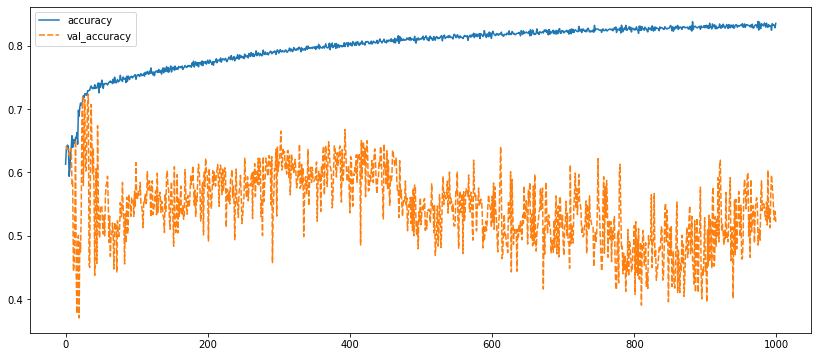

In [ ]:
plt.figure(figsize=(14,6))
sns.lineplot(data = {'accuracy':history.history['accuracy'], 'val_accuracy' : history.history['val_accuracy']})


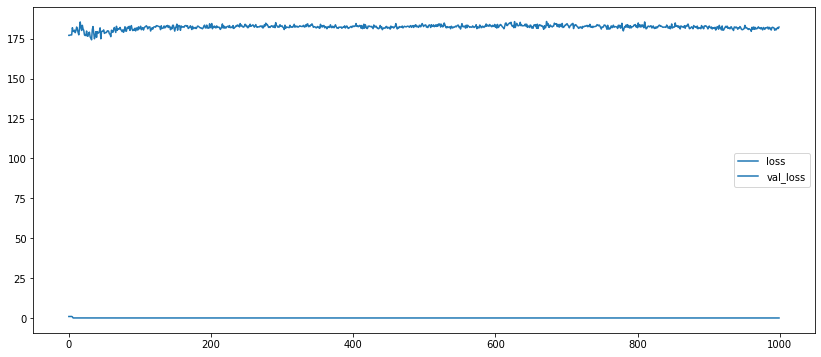

In [ ]:
plt.figure(figsize=(14,6))
sns.lineplot(data = {'loss':history.history['loss']})
sns.lineplot(data = {'val_loss' : history.history['val_loss']})

In [ ]:

testHistory = model.evaluate(Xtest, Ytest, batch_size=batch_size)
print(testHistory)

2/2 [==============================] - 1s 407ms/step - loss: 182.3492 - accuracy: 0.5216
[182.34918212890625, 0.5216119289398193]


In [ ]:
#/content/drive/MyDrive/300epch/
model_json = model.to_json()
with open("/content/model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/model.h5")

In [ ]:
'''model_json = model.to_json()
with open("/content/drive/MyDrive/best_model/model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/drive/MyDrive/best_model/model.h5")'''

'model_json = model.to_json()\nwith open("/content/drive/MyDrive/best_model/model.json", "w") as json_file:\n    json_file.write(model_json)\nmodel.save_weights("/content/drive/MyDrive/best_model/model.h5")'

In [ ]:
if not os.path.exists("result"):
   os.mkdir("result")
for name in os.listdir('/content/input/test/'):
    if name == "385838b7.jpg" or name == "323360-Palmy-u-dvortsa-Ordzhonikidze.jpg":
      colorizeImage('/content/input/test/' + name, shape = (512,768))
      continue
    colorizeImage('/content/input/test/' + name)

(512, 768, 3)
(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(512, 768, 3)
(856, 1280, 3)
